# Data

### Import Required Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import efficientnet_v2, resnet50
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Partition and Visualize Data

In [2]:
df = pd.read_csv('../data/df.csv', sep = '\t')

df['combined'] = df['gender'] + "_" + df['subCategory'] + "_" + df['articleType'] + "_" + \
                 df['season'] + "_" + df['usage']

df

id gender subCategory articleType         season   usage  \
0       9605    Men     Topwear      Shirts    Fall/Winter  Casual   
1       6708    Men     Topwear      Shirts  Spring/Summer  Casual   
2       9648    Men     Topwear      Shirts    Fall/Winter  Formal   
3      29769    Men     Topwear      Shirts  Spring/Summer  Casual   
4      14526    Men     Topwear      Shirts    Fall/Winter  Formal   
...      ...    ...         ...         ...            ...     ...   
13995  33717  Women  Bottomwear    Leggings  Spring/Summer  Casual   
13996  25036  Women  Bottomwear    Leggings    Fall/Winter  Casual   
13997  22463  Women  Bottomwear    Leggings    Fall/Winter  Casual   
13998  23045  Women  Bottomwear    Leggings    Fall/Winter  Casual   
13999  33717  Women  Bottomwear    Leggings  Spring/Summer  Casual   

                                              image_path  gender_enc  \
0               ../data/augmented_images/Shirts/9605.jpg           0   
1               ../data/augmented_images/Shirts/6708.jpg           0   
2               ../data/augmented_images/Shirts/9648.jpg           0   
3              ../data/augmented_images/Shirts/29769.jpg           0   
4              ../data/augmented_images/Shirts/14526.jpg           0   
...                                                  ...         ...   
13995  ../data/augmented_images/Leggings/872_augm_337...           1   
13996  ../data/augmented_images/Leggings/873_augm_250...           1   
13997  ../data/augmented_images/Leggings/874_augm_224...           1   
13998  ../data/augmented_images/Leggings/875_augm_230...           1   
13999  ../data/augmented_images/Leggings/876_augm_337...           1   

       subCategory_enc  articleType_enc  season_enc  usage_enc  \
0                    1                4           0          0   
1                    1                4           1          0   
2                    1                4           0          1   
3                    1                4           1          0   
4                    1                4           0          1   
...                ...              ...         ...        ...   
13995                0                3           1          0   
13996                0                3           0          0   
13997                0                3           0          0   
13998                0                3           0          0   
13999                0                3           1          0   

                                             combined  
0               Men_Topwear_Shirts_Fall/Winter_Casual  
1             Men_Topwear_Shirts_Spring/Summer_Casual  
2               Men_Topwear_Shirts_Fall/Winter_Formal  
3             Men_Topwear_Shirts_Spring/Summer_Casual  
4               Men_Topwear_Shirts_Fall/Winter_Formal  
...                                               ...  
13995  Women_Bottomwear_Leggings_Spring/Summer_Casual  
13996    Women_Bottomwear_Leggings_Fall/Winter_Casual  
13997    Women_Bottomwear_Leggings_Fall/Winter_Casual  
13998    Women_Bottomwear_Leggings_Fall/Winter_Casual  
13999  Women_Bottomwear_Leggings_Spring/Summer_Casual  

[14000 rows x 13 columns]

In [3]:
# Calculate the value counts of the 'combined' column
combined_value_counts = df['combined'].value_counts()

# Find the combined values with a count of 1
combined_values_with_1_count = combined_value_counts[combined_value_counts == 1].index

# Remove rows with these combined values from the DataFrame
df_filtered = df[~df['combined'].isin(combined_values_with_1_count)]

# Split the filtered DataFrame into train and (validation + test) sets while stratifying by 'combined'
train, val_test = train_test_split(df_filtered, test_size=0.2, random_state=123, stratify=df_filtered[['combined']])

# Append the rows with 1 count back to the train set
train = pd.concat([train, df[df['combined'].isin(combined_values_with_1_count)]])

# -------------------------------------------------------------

# Calculate the value counts of the 'combined' column
combined_value_counts = val_test['combined'].value_counts()

# Find the combined values with a count of 1
combined_values_with_1_count = combined_value_counts[combined_value_counts == 1].index

# Remove rows with these combined values from the DataFrame
df_filtered = val_test[~val_test['combined'].isin(combined_values_with_1_count)]

# Separate the (validation + test) sets, stratifying by 'combined'
val, test = train_test_split(df_filtered, test_size=0.5, random_state=123, stratify=df_filtered[['combined']])

# Append the rows with 1 count back to the train set
val = pd.concat([val, val_test[val_test['combined'].isin(combined_values_with_1_count)]])

# -------------------------------------------------------------

# Verify the sizes of train and test sets
print("Original size:", len(df))
print("Train + Validation + Test size:", len(train), '+', len(val), '+', len(test), '=', len(train) + len(val) + len(test))

Original size: 14000
Train + Validation + Test size: 11200 + 1402 + 1398 = 14000


In [45]:
# Define image dimensions
img_height, img_width = 224, 224

# Define batch size
batch_size = 32

y_col = ["subCategory_enc", "articleType_enc", "gender_enc", "season_enc", "usage_enc"]

# Create a custom data generator for training data
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to the range [0, 1]
#     validation_split=0.2  # Specify validation split
)

# Use the flow_from_dataframe method to load and preprocess training images from the DataFrame
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    x_col="image_path",  # Column name in the DataFrame that contains image paths
    y_col=y_col,  # List of columns containing labels
    target_size=(img_height, img_width),
    batch_size=batch_size,
#     subset="training",  # Specify training subset
    class_mode="multi_output",  # Use "multi_output" mode for multiple labels
    shuffle=True,  # Shuffle the data
    seed=123  # Random seed for reproducibility
)

# Use the flow_from_dataframe method to load and preprocess validation images from the DataFrame
validation_generator = datagen.flow_from_dataframe(
    dataframe=val,
    x_col="image_path",  # Column name in the DataFrame that contains image paths
    y_col=y_col,  # List of columns containing labels
    target_size=(img_height, img_width),
    batch_size=batch_size,
#     subset="validation",  # Specify validation subset
    class_mode="multi_output",  # Use "multi_output" mode for multiple labels
    shuffle=False,  # No need to shuffle the validation data
    seed=123  # Random seed for reproducibility
)

# Use the flow_from_dataframe method to load and preprocess test images from the DataFrame
test_generator = datagen.flow_from_dataframe(
    dataframe=test,
    x_col="image_path",  # Column name in the DataFrame that contains image paths
    y_col=y_col,  # List of columns containing labels
    target_size=(img_height, img_width),
    batch_size=batch_size,
#     subset="validation",  # Specify validation subset
    class_mode="multi_output",  # Use "multi_output" mode for multiple labels
    shuffle=False,  # No need to shuffle the validation data
    seed=123  # Random seed for reproducibility
)

Found 11200 validated image filenames.
Found 1402 validated image filenames.
Found 1398 validated image filenames.


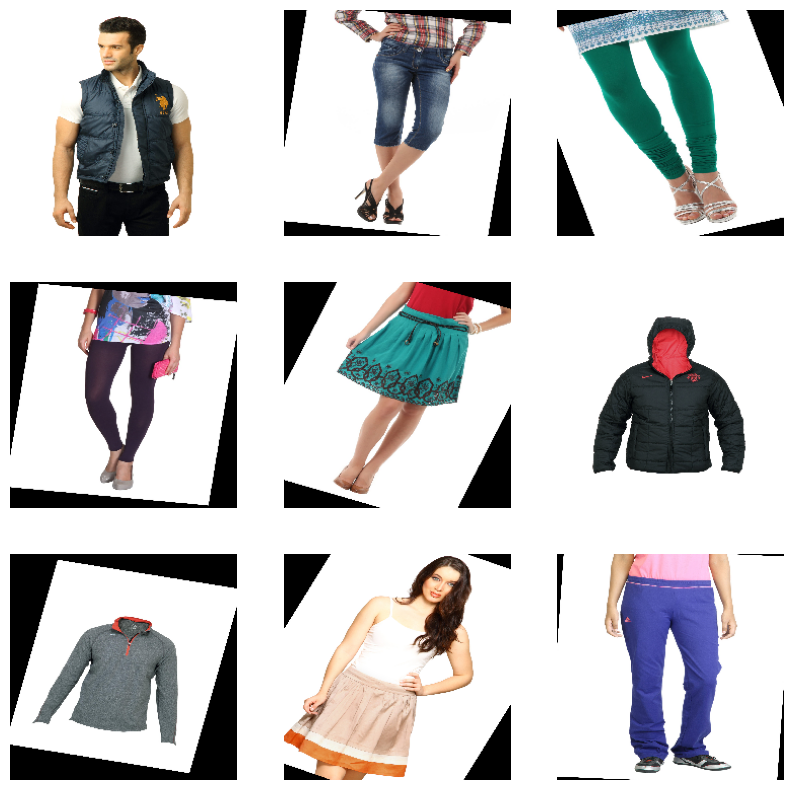

In [6]:
# Generate a batch of images and labels from the train_generator
images, labels = train_generator.next()

# Create a grid for visualization
num_images = min(len(images), 9)  # Limit the number of images to 9 for a 3x3 grid
plt.figure(figsize=(10, 10))

for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
#     plt.title("Label: " + labels[i])
    plt.axis("off")

plt.show()

# Models Training

## Best Learning Rate Finder

In [ ]:
class LRFinder(Callback):
    """Callback that exponentially adjusts the learning rate after each training batch between start_lr and
    end_lr for a maximum number of batches: max_step. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the plot method.
    """

    def __init__(self, start_lr: float = 1e-10, end_lr: float = 1, max_steps: int = 1600, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [ ]:
# lr_finder = LRFinder()
# _ = model.fit(train_generator, epochs=5, callbacks=[lr_finder], verbose=True)
# lr_finder.plot()

## 1. EfficientNetv2-S Model with Reduce LR

### Import the Pre-trained Model

In [11]:
def build_model():
    # Define image dimensions
    img_height, img_width = 224, 224

    # Use the Efficient Net v2-S pretrained model as the feature extractor
    efficient_V2S_model = efficientnet_v2.EfficientNetV2S(include_top=False,
                            input_shape=(img_height, img_width, 3),
                            pooling='avg',
                            weights='imagenet')

    # Freeze the layers of the Efficient Net model to use it as a feature extractor
    for layer in efficient_V2S_model.layers:
        layer.trainable = False

    # Create the multi-output model
    inputs = Input(shape=(img_height, img_width, 3))
    x = efficientnet_v2.preprocess_input(inputs)
    x = efficient_V2S_model(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # Define the number of classes for each output column
    num_classes_gender = len(df['gender'].unique())
    num_classes_articleType = len(df['articleType'].unique())
    num_classes_usage = len(df['usage'].unique())

    # Output layers for each output column
    subCategory_output = Dense(1, activation='sigmoid', name='subCategory_output')(x)
    articleType_output = Dense(num_classes_articleType, activation='softmax', name='articleType_output')(x)
    gender_output = Dense(num_classes_gender, activation='softmax', name='gender_output')(x)
    season_output = Dense(1, activation='sigmoid', name='season_output')(x)
    usage_output = Dense(num_classes_usage, activation='softmax', name='usage_output')(x)

    # Create the model with multiple output layers
    model = Model(inputs=inputs, outputs=[subCategory_output, articleType_output, gender_output, season_output, usage_output])
    return model

In [12]:
min_lr = 1e-4
max_lr = 1e-2
optimizer = Adam(max_lr)

model = build_model()
# Compile the model with appropriate loss functions for each output
model.compile(optimizer=optimizer,
              loss={'subCategory_output': 'binary_crossentropy',
                    'articleType_output': 'sparse_categorical_crossentropy',
                    'gender_output': 'sparse_categorical_crossentropy',
                    'season_output': 'binary_crossentropy',
                    'usage_output': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 efficientnetv2-s (Function  (None, 1280)                 2033136   ['input_4[0][0]']             
 al)                                                      0                                       
                                                                                                  
 flatten_1 (Flatten)         (None, 1280)                 0         ['efficientnetv2-s[0][0]']    
                                                                                                  
 dense_1 (Dense)             (None, 512)                  655872    ['flatten_1[0][0]']     

### Train Model

In [13]:
epochs=100
initial_epoch=0
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            restore_best_weights=True)

checkpoint_filepath = '../models/EfficientNetV2S/weights.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=min_lr)

In [ ]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, initial_epoch=initial_epoch,
                    callbacks=[early_stopping_callback, model_checkpoint_callback, reduce_lr])

Epoch 1/100
350/350 [==============================] - 348s 913ms/step - loss: 4.1448 - subCategory_output_loss: 0.2852 - articleType_output_loss: 1.9795 - gender_output_loss: 0.5880 - season_output_loss: 0.6787 - usage_output_loss: 0.6134 - subCategory_output_accuracy: 0.8758 - articleType_output_accuracy: 0.2820 - gender_output_accuracy: 0.6870 - season_output_accuracy: 0.5763 - usage_output_accuracy: 0.7903 - val_loss: 3.5396 - val_subCategory_output_loss: 0.2060 - val_articleType_output_loss: 1.6840 - val_gender_output_loss: 0.4563 - val_season_output_loss: 0.6564 - val_usage_output_loss: 0.5369 - val_subCategory_output_accuracy: 0.9094 - val_articleType_output_accuracy: 0.3652 - val_gender_output_accuracy: 0.7981 - val_season_output_accuracy: 0.6084 - val_usage_output_accuracy: 0.8046 - lr: 0.0100
Epoch 2/100
350/350 [==============================] - 314s 897ms/step - loss: 3.5836 - subCategory_output_loss: 0.1803 - articleType_output_loss: 1.6889 - gender_output_loss: 0.4894 - s

In [14]:
model.load_weights(checkpoint_filepath)

### Training Visualization

In [ ]:
# Combine the lists into a 2D array
accuracy_matrix = np.array([history.history['subCategory_output_accuracy'],
                            history.history['articleType_output_accuracy'],
                            history.history['gender_output_accuracy'],
                            history.history['season_output_accuracy'],
                            history.history['usage_output_accuracy']])

# Calculate the average for each position (across all lists)
accuracy = np.mean(accuracy_matrix, axis=0)

In [ ]:
# Combine the lists into a 2D array
val_accuracy_matrix = np.array([history.history['val_subCategory_output_accuracy'],
                            history.history['val_articleType_output_accuracy'],
                            history.history['val_gender_output_accuracy'],
                            history.history['val_season_output_accuracy'],
                            history.history['val_usage_output_accuracy']])

# Calculate the average for each position (across all lists)
val_accuracy = np.mean(val_accuracy_matrix, axis=0)

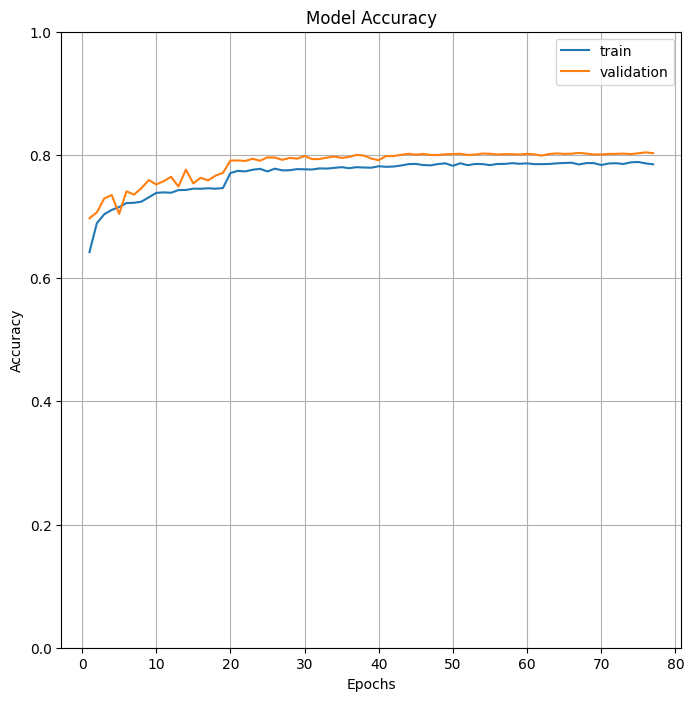

In [ ]:
plt.figure(figsize=(8, 8))
epochs_range= range(initial_epoch+1, 77+1)
plt.plot(epochs_range, accuracy, label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

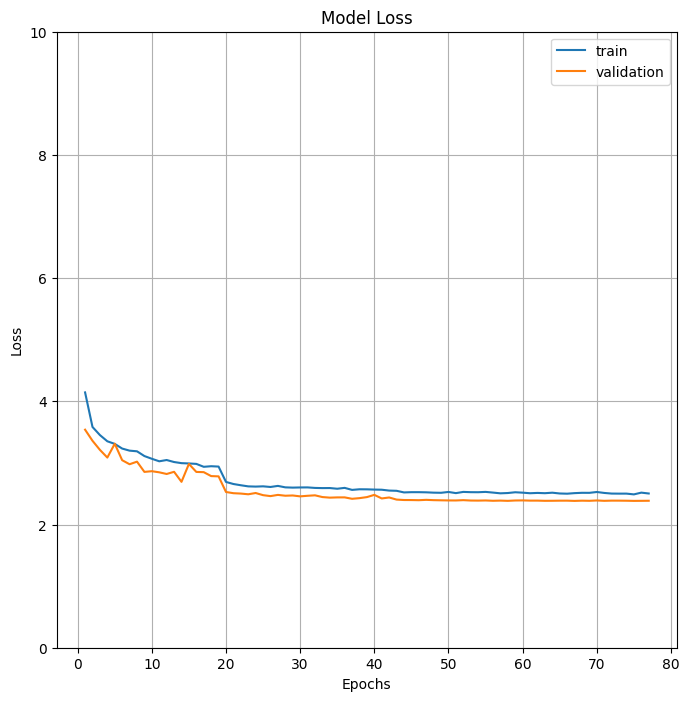

In [ ]:
plt.figure(figsize=(8, 8))
epochs_range= range(initial_epoch+1, 77+1)
plt.plot( epochs_range, history.history['loss'], label="Training Loss")
plt.plot(epochs_range, history.history['val_loss'], label="Validation Loss")
plt.axis(ymin=0,ymax=10)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

## 2. ResNet50 Model with Reduce LR

### Import the Pre-trained Model

In [15]:
def build_model():
    # Define image dimensions
    img_height, img_width = 224, 224

    # Use the ResNet50 pretrained model as the feature extractor
    resnet_model = resnet50.ResNet50(include_top=False,
                            input_shape=(img_height, img_width, 3),
                            pooling='avg',
                            weights='imagenet')

    # Freeze the layers of the ResNet50 model to use it as a feature extractor
    for layer in resnet_model.layers:
        layer.trainable = False

    # Create the multi-output model
    inputs = Input(shape=(img_height, img_width, 3))
    x = resnet50.preprocess_input(inputs)
    x = resnet_model(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # Define the number of classes for each output column
    num_classes_gender = len(df['gender'].unique())
    num_classes_articleType = len(df['articleType'].unique())
    # num_classes_baseColour = len(df['baseColour'].unique())
    num_classes_usage = len(df['usage'].unique())

    # Output layers for each output column
    subCategory_output = Dense(1, activation='sigmoid', name='subCategory_output')(x)
    articleType_output = Dense(num_classes_articleType, activation='softmax', name='articleType_output')(x)
    gender_output = Dense(num_classes_gender, activation='softmax', name='gender_output')(x)
    # baseColour_output = Dense(num_classes_baseColour, activation='softmax', name='baseColour_output')(x)
    season_output = Dense(1, activation='sigmoid', name='season_output')(x)
    usage_output = Dense(num_classes_usage, activation='softmax', name='usage_output')(x)

    # Create the model with multiple output layers
    model = Model(inputs=inputs, outputs=[subCategory_output, articleType_output, gender_output, season_output, usage_output])
    return model

In [16]:
min_lr = 1e-4
max_lr = 1e-2
optimizer = Adam(max_lr)

model2 = build_model()
# Compile the model with appropriate loss functions for each output
model2.compile(optimizer=optimizer,
              loss={'subCategory_output': 'binary_crossentropy',
                    'articleType_output': 'sparse_categorical_crossentropy',
                    'gender_output': 'sparse_categorical_crossentropy',
                    # 'baseColour_output': 'sparse_categorical_crossentropy',
                    'season_output': 'binary_crossentropy',
                    'usage_output': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 224, 224, 3)          0         ['input_6[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)          0         ['tf.__operators__.getitem[0][
 )                                                                  0]']                          
                                                                                            

### Train Model

In [18]:
epochs=100
initial_epoch=0
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            restore_best_weights=True)

checkpoint_filepath = '../models/ResNet50/weights.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=min_lr)

In [ ]:
history2 = model2.fit(train_generator, validation_data=validation_generator, epochs=epochs, initial_epoch=initial_epoch,
                    callbacks=[early_stopping_callback, model_checkpoint_callback, reduce_lr])

Epoch 1/100
350/350 [==============================] - 288s 798ms/step - loss: 4.1995 - subCategory_output_loss: 0.2757 - articleType_output_loss: 1.9808 - gender_output_loss: 0.6213 - season_output_loss: 0.7164 - usage_output_loss: 0.6054 - subCategory_output_accuracy: 0.8982 - articleType_output_accuracy: 0.2745 - gender_output_accuracy: 0.6775 - season_output_accuracy: 0.5612 - usage_output_accuracy: 0.7905 - val_loss: 3.4990 - val_subCategory_output_loss: 0.1713 - val_articleType_output_loss: 1.6613 - val_gender_output_loss: 0.4378 - val_season_output_loss: 0.6704 - val_usage_output_loss: 0.5582 - val_subCategory_output_accuracy: 0.9351 - val_articleType_output_accuracy: 0.3923 - val_gender_output_accuracy: 0.7882 - val_season_output_accuracy: 0.5792 - val_usage_output_accuracy: 0.8117 - lr: 0.0100
Epoch 2/100
350/350 [==============================] - 286s 818ms/step - loss: 3.5503 - subCategory_output_loss: 0.1552 - articleType_output_loss: 1.6752 - gender_output_loss: 0.4891 - s

In [19]:
model2.load_weights(checkpoint_filepath)

### Training Visualization

In [ ]:
# Combine the lists into a 2D array
accuracy_matrix = np.array([history2.history['subCategory_output_accuracy'],
                            history2.history['articleType_output_accuracy'],
                            history2.history['gender_output_accuracy'],
                            history2.history['season_output_accuracy'],
                            history2.history['usage_output_accuracy']])

# Calculate the average for each position (across all lists)
accuracy = np.mean(accuracy_matrix, axis=0)

In [ ]:
# Combine the lists into a 2D array
val_accuracy_matrix = np.array([history2.history['val_subCategory_output_accuracy'],
                            history2.history['val_articleType_output_accuracy'],
                            history2.history['val_gender_output_accuracy'],
                            history2.history['val_season_output_accuracy'],
                            history2.history['val_usage_output_accuracy']])

# Calculate the average for each position (across all lists)
val_accuracy = np.mean(val_accuracy_matrix, axis=0)

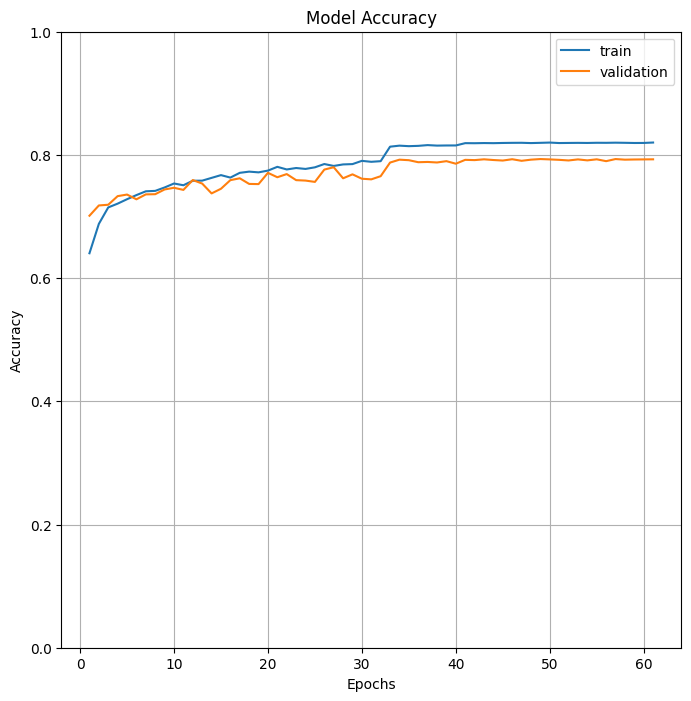

In [ ]:
plt.figure(figsize=(8, 8))
epochs_range= range(initial_epoch+1, 61+1)
plt.plot(epochs_range, accuracy, label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

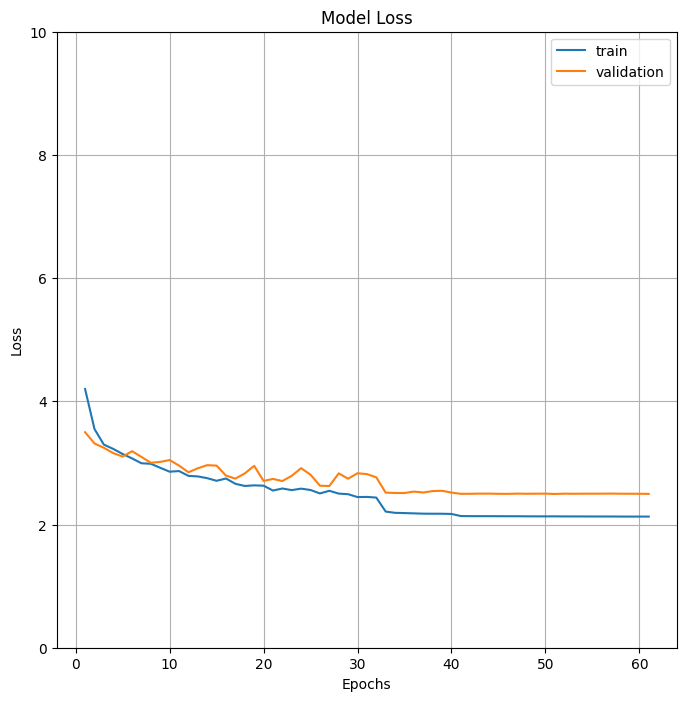

In [ ]:
plt.figure(figsize=(8, 8))
epochs_range= range(initial_epoch+1, 61+1)
plt.plot( epochs_range, history2.history['loss'], label="Training Loss")
plt.plot(epochs_range, history2.history['val_loss'], label="Validation Loss")
plt.axis(ymin=0,ymax=10)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

## 3. EfficientNetv2-S Model without changing LR

### Import the Pre-trained Model

In [20]:
def build_model():
    # Define image dimensions
    img_height, img_width = 224, 224

    # Use the Efficient Net v2-S pretrained model as the feature extractor
    efficient_V2S_model = efficientnet_v2.EfficientNetV2S(include_top=False,
                            input_shape=(img_height, img_width, 3),
                            pooling='avg',
                            weights='imagenet')

    # Freeze the layers of the Efficient Net model to use it as a feature extractor
    for layer in efficient_V2S_model.layers:
        layer.trainable = False

    # Create the multi-output model
    inputs = Input(shape=(img_height, img_width, 3))
    x = efficientnet_v2.preprocess_input(inputs)
    x = efficient_V2S_model(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # Define the number of classes for each output column
    num_classes_gender = len(df['gender'].unique())
    num_classes_articleType = len(df['articleType'].unique())
    num_classes_usage = len(df['usage'].unique())

    # Output layers for each output column
    subCategory_output = Dense(1, activation='sigmoid', name='subCategory_output')(x)
    articleType_output = Dense(num_classes_articleType, activation='softmax', name='articleType_output')(x)
    gender_output = Dense(num_classes_gender, activation='softmax', name='gender_output')(x)
    season_output = Dense(1, activation='sigmoid', name='season_output')(x)
    usage_output = Dense(num_classes_usage, activation='softmax', name='usage_output')(x)

    # Create the model with multiple output layers
    model = Model(inputs=inputs, outputs=[subCategory_output, articleType_output, gender_output, season_output, usage_output])
    return model

In [21]:
model3 = build_model()
# Compile the model with appropriate loss functions for each output
model3.compile(optimizer='adam',
              loss={'subCategory_output': 'binary_crossentropy',
                    'articleType_output': 'sparse_categorical_crossentropy',
                    'gender_output': 'sparse_categorical_crossentropy',
                    'season_output': 'binary_crossentropy',
                    'usage_output': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 efficientnetv2-s (Function  (None, 1280)                 2033136   ['input_8[0][0]']             
 al)                                                      0                                       
                                                                                                  
 flatten_3 (Flatten)         (None, 1280)                 0         ['efficientnetv2-s[0][0]']    
                                                                                                  
 dense_3 (Dense)             (None, 512)                  655872    ['flatten_3[0][0]']     

### Train Model

In [22]:
epochs=100
initial_epoch=0
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            restore_best_weights=True)

checkpoint_filepath = '../models/EfficientNetV2S_stable/weights.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history3 = model3.fit(train_generator, validation_data=validation_generator, epochs=epochs, initial_epoch=initial_epoch,
                    callbacks=[early_stopping_callback, model_checkpoint_callback])

Epoch 1/100
350/350 [==============================] - 323s 869ms/step - loss: 4.1710 - subCategory_output_loss: 0.3143 - articleType_output_loss: 2.0278 - gender_output_loss: 0.5722 - season_output_loss: 0.6715 - usage_output_loss: 0.5853 - subCategory_output_accuracy: 0.8636 - articleType_output_accuracy: 0.2798 - gender_output_accuracy: 0.6981 - season_output_accuracy: 0.5771 - usage_output_accuracy: 0.7954 - val_loss: 3.5868 - val_subCategory_output_loss: 0.2034 - val_articleType_output_loss: 1.7330 - val_gender_output_loss: 0.4826 - val_season_output_loss: 0.6448 - val_usage_output_loss: 0.5229 - val_subCategory_output_accuracy: 0.9180 - val_articleType_output_accuracy: 0.3845 - val_gender_output_accuracy: 0.7789 - val_season_output_accuracy: 0.6312 - val_usage_output_accuracy: 0.8153
Epoch 2/100
350/350 [==============================] - 283s 810ms/step - loss: 3.5874 - subCategory_output_loss: 0.2004 - articleType_output_loss: 1.6864 - gender_output_loss: 0.5015 - season_output_

In [23]:
model3.load_weights(checkpoint_filepath)

### Training Visualization

In [ ]:
# Combine the lists into a 2D array
accuracy_matrix = np.array([history3.history['subCategory_output_accuracy'],
                            history3.history['articleType_output_accuracy'],
                            history3.history['gender_output_accuracy'],
                            history3.history['season_output_accuracy'],
                            history3.history['usage_output_accuracy']])

# Calculate the average for each position (across all lists)
accuracy = np.mean(accuracy_matrix, axis=0)

In [ ]:
# Combine the lists into a 2D array
val_accuracy_matrix = np.array([history3.history['val_subCategory_output_accuracy'],
                            history3.history['val_articleType_output_accuracy'],
                            history3.history['val_gender_output_accuracy'],
                            history3.history['val_season_output_accuracy'],
                            history3.history['val_usage_output_accuracy']])

# Calculate the average for each position (across all lists)
val_accuracy = np.mean(val_accuracy_matrix, axis=0)

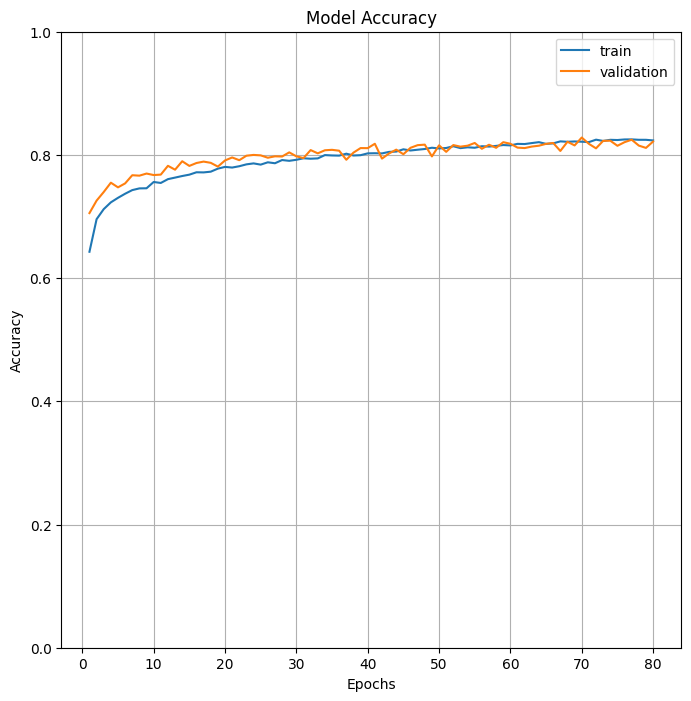

In [ ]:
plt.figure(figsize=(8, 8))
epochs_range= range(initial_epoch+1, 80+1)
plt.plot(epochs_range, accuracy, label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

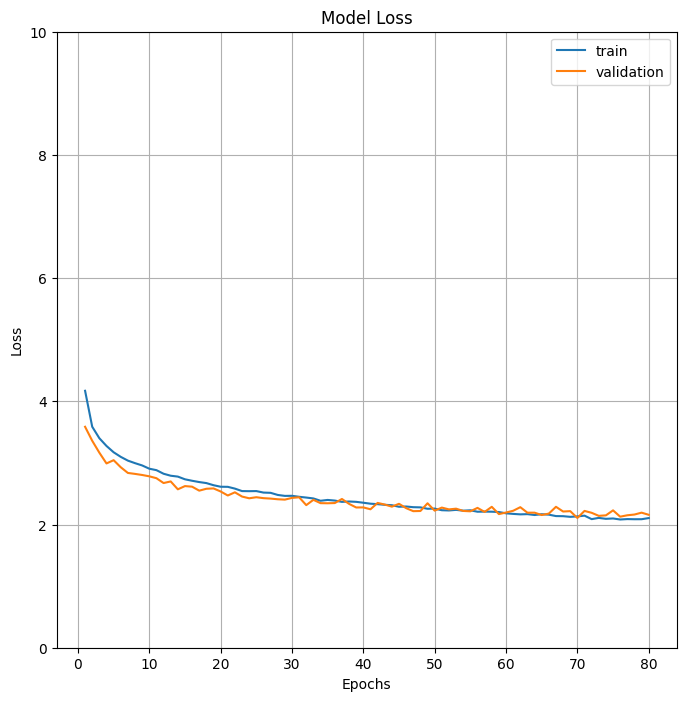

In [ ]:
plt.figure(figsize=(8, 8))
epochs_range= range(initial_epoch+1, 80+1)
plt.plot( epochs_range, history3.history['loss'], label="Training Loss")
plt.plot(epochs_range, history3.history['val_loss'], label="Validation Loss")
plt.axis(ymin=0,ymax=10)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

## 4. ResNet50 Model without changing LR

### Import the Pre-trained Model

In [24]:
def build_model():
    # Define image dimensions
    img_height, img_width = 224, 224

    # Use the ResNet50 pretrained model as the feature extractor
    resnet_model = resnet50.ResNet50(include_top=False,
                            input_shape=(img_height, img_width, 3),
                            pooling='avg',
                            weights='imagenet')

    # Freeze the layers of the ResNet50 model to use it as a feature extractor
    for layer in resnet_model.layers:
        layer.trainable = False

    # Create the multi-output model
    inputs = Input(shape=(img_height, img_width, 3))
    x = resnet50.preprocess_input(inputs)
    x = resnet_model(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # Define the number of classes for each output column
    num_classes_gender = len(df['gender'].unique())
    num_classes_articleType = len(df['articleType'].unique())
    num_classes_usage = len(df['usage'].unique())

    # Output layers for each output column
    subCategory_output = Dense(1, activation='sigmoid', name='subCategory_output')(x)
    articleType_output = Dense(num_classes_articleType, activation='softmax', name='articleType_output')(x)
    gender_output = Dense(num_classes_gender, activation='softmax', name='gender_output')(x)
    season_output = Dense(1, activation='sigmoid', name='season_output')(x)
    usage_output = Dense(num_classes_usage, activation='softmax', name='usage_output')(x)

    # Create the model with multiple output layers
    model = Model(inputs=inputs, outputs=[subCategory_output, articleType_output, gender_output, season_output, usage_output])
    return model

In [25]:
model4 = build_model()
# Compile the model with appropriate loss functions for each output
model4.compile(optimizer='adam',
              loss={'subCategory_output': 'binary_crossentropy',
                    'articleType_output': 'sparse_categorical_crossentropy',
                    'gender_output': 'sparse_categorical_crossentropy',
                    'season_output': 'binary_crossentropy',
                    'usage_output': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])
model4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_1  (None, 224, 224, 3)          0         ['input_10[0][0]']            
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)          0         ['tf.__operators__.getitem_1[0
 da)                                                                ][0]']                        
                                                                                            

### Train Model

In [26]:
epochs=100
initial_epoch=0
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            restore_best_weights=True)

checkpoint_filepath = '../models/ResNet50_stable/weights.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history4 = model4.fit(train_generator, validation_data=validation_generator, epochs=epochs, initial_epoch=initial_epoch,
                    callbacks=[early_stopping_callback, model_checkpoint_callback])

Epoch 1/100
350/350 [==============================] - 276s 768ms/step - loss: 4.1466 - subCategory_output_loss: 0.2942 - articleType_output_loss: 2.0065 - gender_output_loss: 0.5650 - season_output_loss: 0.6841 - usage_output_loss: 0.5967 - subCategory_output_accuracy: 0.8846 - articleType_output_accuracy: 0.3012 - gender_output_accuracy: 0.7071 - season_output_accuracy: 0.5679 - usage_output_accuracy: 0.7888 - val_loss: 3.5918 - val_subCategory_output_loss: 0.1893 - val_articleType_output_loss: 1.7130 - val_gender_output_loss: 0.4605 - val_season_output_loss: 0.6769 - val_usage_output_loss: 0.5522 - val_subCategory_output_accuracy: 0.9387 - val_articleType_output_accuracy: 0.4023 - val_gender_output_accuracy: 0.7903 - val_season_output_accuracy: 0.5642 - val_usage_output_accuracy: 0.7996
Epoch 2/100
350/350 [==============================] - 290s 829ms/step - loss: 3.4482 - subCategory_output_loss: 0.1762 - articleType_output_loss: 1.6255 - gender_output_loss: 0.4490 - season_output_

In [27]:
model4.load_weights(checkpoint_filepath)

### Training Visualization

In [ ]:
# Combine the lists into a 2D array
accuracy_matrix = np.array([history4.history['subCategory_output_accuracy'],
                            history4.history['articleType_output_accuracy'],
                            history4.history['gender_output_accuracy'],
                            history4.history['season_output_accuracy'],
                            history4.history['usage_output_accuracy']])

# Calculate the average for each position (across all lists)
accuracy = np.mean(accuracy_matrix, axis=0)

In [ ]:
# Combine the lists into a 2D array
val_accuracy_matrix = np.array([history4.history['val_subCategory_output_accuracy'],
                            history4.history['val_articleType_output_accuracy'],
                            history4.history['val_gender_output_accuracy'],
                            history4.history['val_season_output_accuracy'],
                            history4.history['val_usage_output_accuracy']])

# Calculate the average for each position (across all lists)
val_accuracy = np.mean(val_accuracy_matrix, axis=0)

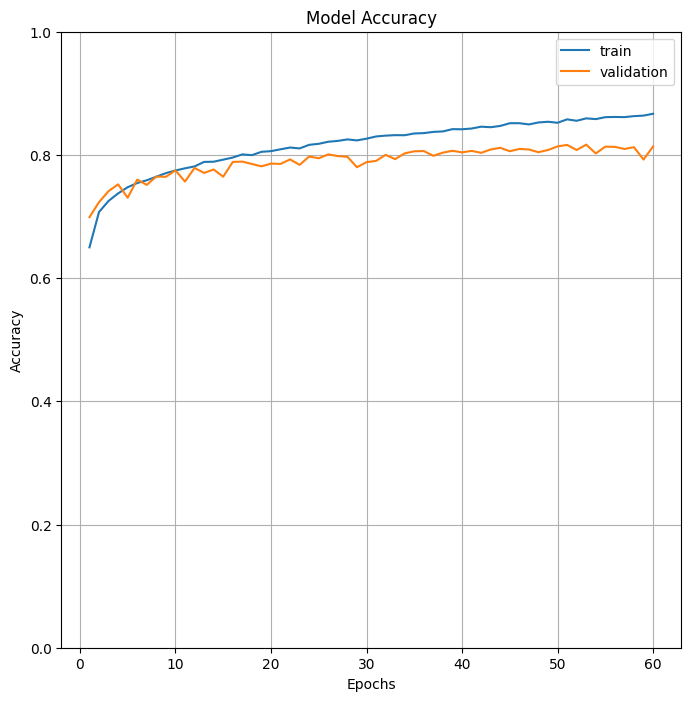

In [ ]:
plt.figure(figsize=(8, 8))
epochs_range= range(initial_epoch+1, 60+1)
plt.plot(epochs_range, accuracy, label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

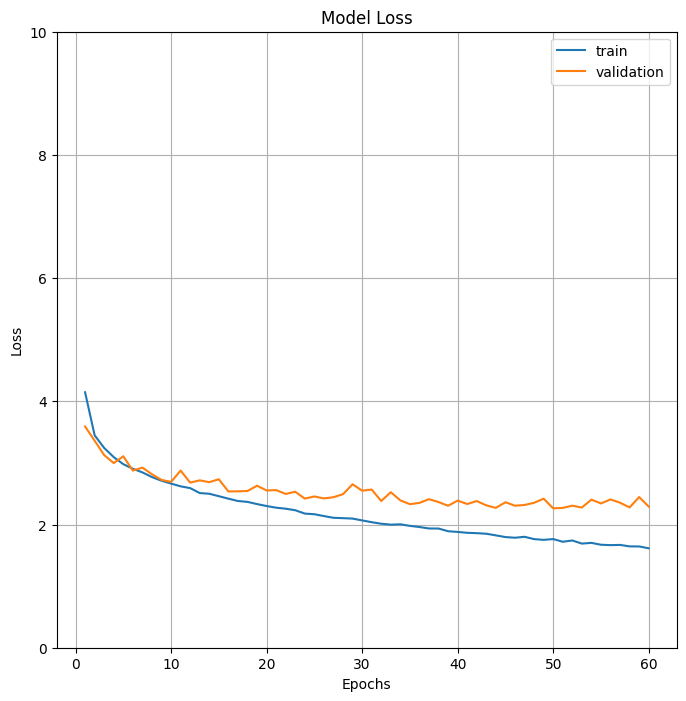

In [ ]:
plt.figure(figsize=(8, 8))
epochs_range= range(initial_epoch+1, 60+1)
plt.plot( epochs_range, history4.history['loss'], label="Training Loss")
plt.plot(epochs_range, history4.history['val_loss'], label="Validation Loss")
plt.axis(ymin=0,ymax=10)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

## 5. EfficientNetv2-S Model Grayscale Images

### Import the Pre-trained Model

In [28]:
def build_model():
    # Define image dimensions
    img_height, img_width = 224, 224

    # Use the Efficient Net v2-S pretrained model as the feature extractor
    efficient_V2S_model = efficientnet_v2.EfficientNetV2S(include_top=False,
                            input_shape=(img_height, img_width, 3),
                            pooling='avg',
                            weights='imagenet')

    # Freeze the layers of the Efficient Net model to use it as a feature extractor
    for layer in efficient_V2S_model.layers:
        layer.trainable = False

    # Create the multi-output model
    inputs = Input(shape=(img_height, img_width, 3))
    x = efficientnet_v2.preprocess_input(inputs)
    x = Lambda(lambda img: tf.image.rgb_to_grayscale(img))(x)
    x = Lambda(lambda img: tf.image.grayscale_to_rgb(img))(x)
    x = efficient_V2S_model(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # Define the number of classes for each output column
    num_classes_gender = len(df['gender'].unique())
    num_classes_articleType = len(df['articleType'].unique())
    # num_classes_baseColour = len(df['baseColour'].unique())
    num_classes_usage = len(df['usage'].unique())

    # Output layers for each output column
    subCategory_output = Dense(1, activation='sigmoid', name='subCategory_output')(x)
    articleType_output = Dense(num_classes_articleType, activation='softmax', name='articleType_output')(x)
    gender_output = Dense(num_classes_gender, activation='softmax', name='gender_output')(x)
    # baseColour_output = Dense(num_classes_baseColour, activation='softmax', name='baseColour_output')(x)
    season_output = Dense(1, activation='sigmoid', name='season_output')(x)
    usage_output = Dense(num_classes_usage, activation='softmax', name='usage_output')(x)

    # Create the model with multiple output layers
    model = Model(inputs=inputs, outputs=[subCategory_output, articleType_output, gender_output, season_output, usage_output])
    return model

In [29]:
model5 = build_model()
# Compile the model with appropriate loss functions for each output
model5.compile(optimizer='adam',
              loss={'subCategory_output': 'binary_crossentropy',
                    'articleType_output': 'sparse_categorical_crossentropy',
                    'gender_output': 'sparse_categorical_crossentropy',
                    'season_output': 'binary_crossentropy',
                    'usage_output': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])
model5.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 224, 224, 1)          0         ['input_12[0][0]']            
                                                                                                  
 lambda_1 (Lambda)           (None, 224, 224, 3)          0         ['lambda[0][0]']              
                                                                                                  
 efficientnetv2-s (Function  (None, 1280)                 2033136   ['lambda_1[0][0]']            
 al)                                                      0                                 

### Train Model

In [30]:
epochs=100
initial_epoch=0
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            restore_best_weights=True)

checkpoint_filepath = '../models/EfficientNetV2S_gray/weights.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [15]:
history5 = model5.fit(train_generator, validation_data=validation_generator, epochs=epochs, initial_epoch=initial_epoch,
                    callbacks=[early_stopping_callback, model_checkpoint_callback])

Epoch 1/100
350/350 [==============================] - 314s 824ms/step - loss: 4.1765 - subCategory_output_loss: 0.3095 - articleType_output_loss: 2.0230 - gender_output_loss: 0.5816 - season_output_loss: 0.6757 - usage_output_loss: 0.5868 - subCategory_output_accuracy: 0.8638 - articleType_output_accuracy: 0.2854 - gender_output_accuracy: 0.6886 - season_output_accuracy: 0.5702 - usage_output_accuracy: 0.7995 - val_loss: 3.6796 - val_subCategory_output_loss: 0.1936 - val_articleType_output_loss: 1.7482 - val_gender_output_loss: 0.5344 - val_season_output_loss: 0.6687 - val_usage_output_loss: 0.5348 - val_subCategory_output_accuracy: 0.9201 - val_articleType_output_accuracy: 0.3852 - val_gender_output_accuracy: 0.7061 - val_season_output_accuracy: 0.5635 - val_usage_output_accuracy: 0.7989
Epoch 2/100
350/350 [==============================] - 271s 775ms/step - loss: 3.5993 - subCategory_output_loss: 0.2036 - articleType_output_loss: 1.6851 - gender_output_loss: 0.5122 - season_output_

In [31]:
model5.load_weights(checkpoint_filepath)

### Training Visualization

In [16]:
# Combine the lists into a 2D array
accuracy_matrix = np.array([history5.history['subCategory_output_accuracy'],
                            history5.history['articleType_output_accuracy'],
                            history5.history['gender_output_accuracy'],
                            history5.history['season_output_accuracy'],
                            history5.history['usage_output_accuracy']])

# Calculate the average for each position (across all lists)
accuracy = np.mean(accuracy_matrix, axis=0)

In [17]:
# Combine the lists into a 2D array
val_accuracy_matrix = np.array([history5.history['val_subCategory_output_accuracy'],
                            history5.history['val_articleType_output_accuracy'],
                            history5.history['val_gender_output_accuracy'],
                            history5.history['val_season_output_accuracy'],
                            history5.history['val_usage_output_accuracy']])

# Calculate the average for each position (across all lists)
val_accuracy = np.mean(val_accuracy_matrix, axis=0)

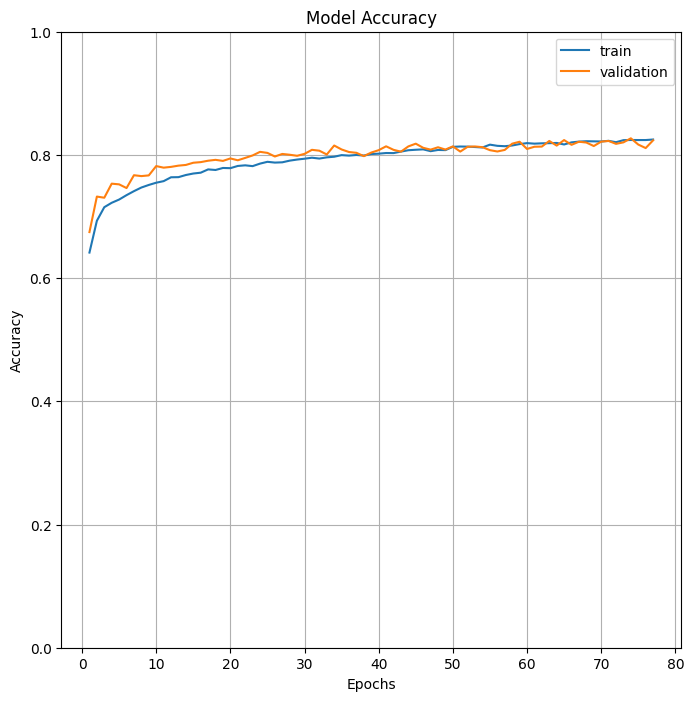

In [18]:
plt.figure(figsize=(8, 8))
epochs_range= range(initial_epoch+1, 77+1)
plt.plot(epochs_range, accuracy, label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

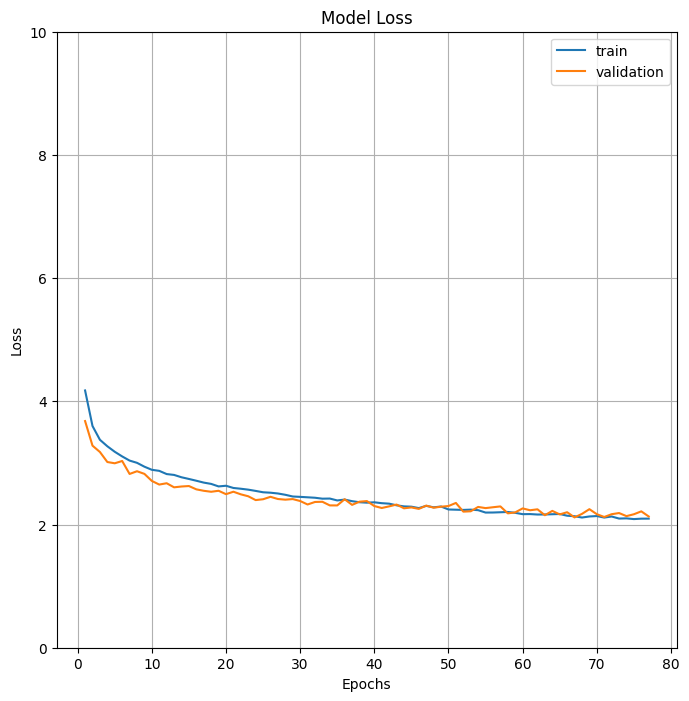

In [19]:
plt.figure(figsize=(8, 8))
epochs_range= range(initial_epoch+1, 77+1)
plt.plot( epochs_range, history5.history['loss'], label="Training Loss")
plt.plot(epochs_range, history5.history['val_loss'], label="Validation Loss")
plt.axis(ymin=0,ymax=10)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

## 6. ResNet50 Model Grayscale images

### Import the Pre-trained Model

In [32]:
def build_model():
    # Define image dimensions
    img_height, img_width = 224, 224

    # Use the ResNet50 pretrained model as the feature extractor
    resnet_model = resnet50.ResNet50(include_top=False,
                            input_shape=(img_height, img_width, 3),
                            pooling='avg',
                            weights='imagenet')

    # Freeze the layers of the ResNet50 model to use it as a feature extractor
    for layer in resnet_model.layers:
        layer.trainable = False

    # Create the multi-output model
    inputs = Input(shape=(img_height, img_width, 3))
    x = resnet50.preprocess_input(inputs)
    x = Lambda(lambda img: tf.image.rgb_to_grayscale(img))(x)
    x = Lambda(lambda img: tf.image.grayscale_to_rgb(img))(x)
    x = resnet_model(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # Define the number of classes for each output column
    num_classes_gender = len(df['gender'].unique())
    num_classes_articleType = len(df['articleType'].unique())
    # num_classes_baseColour = len(df['baseColour'].unique())
    num_classes_usage = len(df['usage'].unique())

    # Output layers for each output column
    subCategory_output = Dense(1, activation='sigmoid', name='subCategory_output')(x)
    articleType_output = Dense(num_classes_articleType, activation='softmax', name='articleType_output')(x)
    gender_output = Dense(num_classes_gender, activation='softmax', name='gender_output')(x)
    # baseColour_output = Dense(num_classes_baseColour, activation='softmax', name='baseColour_output')(x)
    season_output = Dense(1, activation='sigmoid', name='season_output')(x)
    usage_output = Dense(num_classes_usage, activation='softmax', name='usage_output')(x)

    # Create the model with multiple output layers
    model = Model(inputs=inputs, outputs=[subCategory_output, articleType_output, gender_output, season_output, usage_output])
    return model

In [33]:
model6 = build_model()
# Compile the model with appropriate loss functions for each output
model6.compile(optimizer='adam',
              loss={'subCategory_output': 'binary_crossentropy',
                    'articleType_output': 'sparse_categorical_crossentropy',
                    'gender_output': 'sparse_categorical_crossentropy',
                    'season_output': 'binary_crossentropy',
                    'usage_output': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])
model6.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_2  (None, 224, 224, 3)          0         ['input_14[0][0]']            
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)          0         ['tf.__operators__.getitem_2[0
 da)                                                                ][0]']                        
                                                                                            

### Train Model

In [34]:
epochs=100
initial_epoch=0
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            restore_best_weights=True)

checkpoint_filepath = '../models/ResNet50_gray/weights.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [23]:
history6 = model6.fit(train_generator, validation_data=validation_generator, epochs=epochs, initial_epoch=initial_epoch,
                    callbacks=[early_stopping_callback, model_checkpoint_callback])

Epoch 1/100
350/350 [==============================] - 263s 730ms/step - loss: 4.2011 - subCategory_output_loss: 0.3021 - articleType_output_loss: 2.0421 - gender_output_loss: 0.5843 - season_output_loss: 0.6838 - usage_output_loss: 0.5887 - subCategory_output_accuracy: 0.8865 - articleType_output_accuracy: 0.2821 - gender_output_accuracy: 0.6848 - season_output_accuracy: 0.5582 - usage_output_accuracy: 0.7887 - val_loss: 3.6389 - val_subCategory_output_loss: 0.1925 - val_articleType_output_loss: 1.7419 - val_gender_output_loss: 0.4889 - val_season_output_loss: 0.6695 - val_usage_output_loss: 0.5461 - val_subCategory_output_accuracy: 0.9301 - val_articleType_output_accuracy: 0.3759 - val_gender_output_accuracy: 0.7668 - val_season_output_accuracy: 0.5806 - val_usage_output_accuracy: 0.7974
Epoch 2/100
350/350 [==============================] - 257s 734ms/step - loss: 3.4740 - subCategory_output_loss: 0.1715 - articleType_output_loss: 1.6452 - gender_output_loss: 0.4601 - season_output_

In [35]:
model6.load_weights(checkpoint_filepath)

### Training Visualization

In [24]:
# Combine the lists into a 2D array
accuracy_matrix = np.array([history6.history['subCategory_output_accuracy'],
                            history6.history['articleType_output_accuracy'],
                            history6.history['gender_output_accuracy'],
                            history6.history['season_output_accuracy'],
                            history6.history['usage_output_accuracy']])

# Calculate the average for each position (across all lists)
accuracy = np.mean(accuracy_matrix, axis=0)

In [25]:
# Combine the lists into a 2D array
val_accuracy_matrix = np.array([history6.history['val_subCategory_output_accuracy'],
                            history6.history['val_articleType_output_accuracy'],
                            history6.history['val_gender_output_accuracy'],
                            history6.history['val_season_output_accuracy'],
                            history6.history['val_usage_output_accuracy']])

# Calculate the average for each position (across all lists)
val_accuracy = np.mean(val_accuracy_matrix, axis=0)

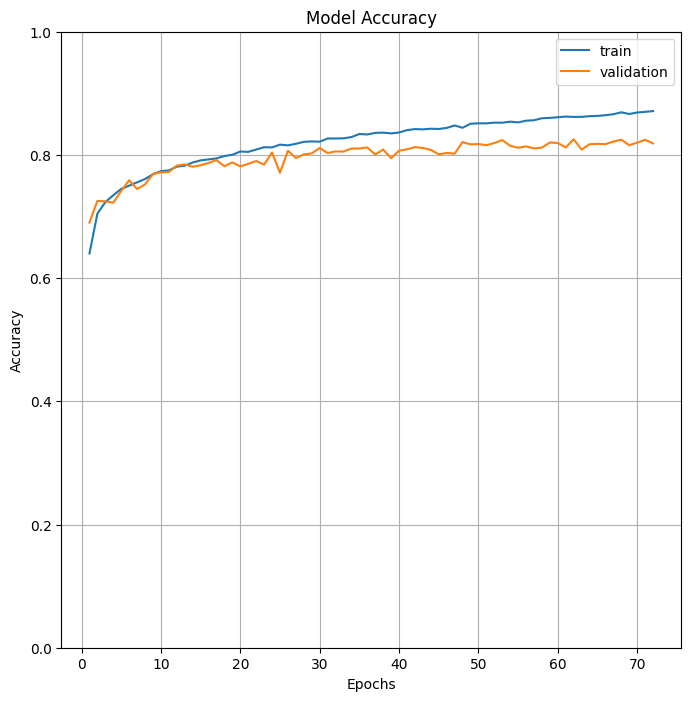

In [29]:
plt.figure(figsize=(8, 8))
epochs_range= range(initial_epoch+1, 72+1)
plt.plot(epochs_range, accuracy, label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

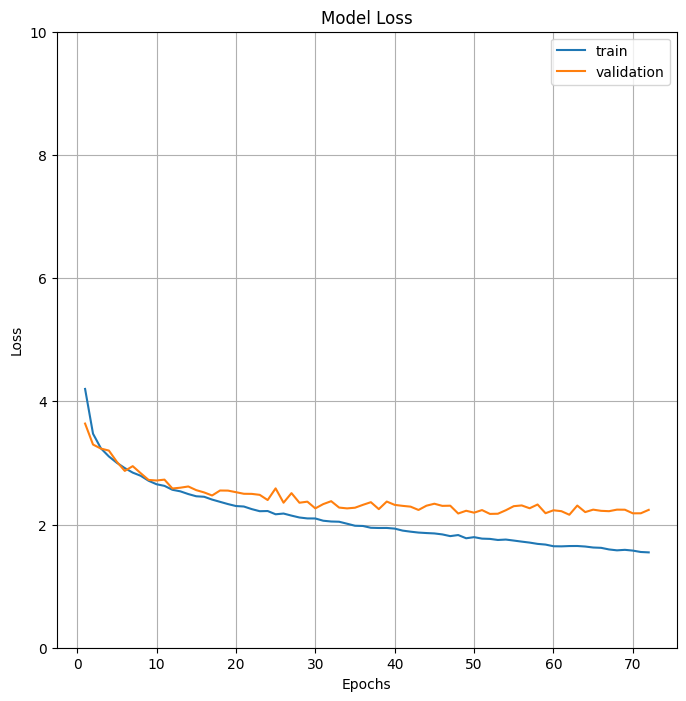

In [30]:
plt.figure(figsize=(8, 8))
epochs_range= range(initial_epoch+1, 72+1)
plt.plot( epochs_range, history6.history['loss'], label="Training Loss")
plt.plot(epochs_range, history6.history['val_loss'], label="Validation Loss")
plt.axis(ymin=0,ymax=10)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

## 7. EfficientNetv2-S Model Grayscale Images with trainable Top Pre-Trained Layers

### Import the Pre-trained Model

In [36]:
def build_model():
    # Define image dimensions
    img_height, img_width = 224, 224

    # Use the Efficient Net v2-S pretrained model as the feature extractor
    efficient_V2S_model = efficientnet_v2.EfficientNetV2S(include_top=False,
                            input_shape=(img_height, img_width, 3),
                            pooling='avg',
                            weights='imagenet')

    # Fine-tune from this layer onwards
    fine_tune_at = 450

    # Freeze the layers of the Efficient Net model (514 layers) to use it as a feature extractor
    for layer in efficient_V2S_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Create the multi-output model
    inputs = Input(shape=(img_height, img_width, 3))
    x = efficientnet_v2.preprocess_input(inputs)
    x = Lambda(lambda img: tf.image.rgb_to_grayscale(img))(x)
    x = Lambda(lambda img: tf.image.grayscale_to_rgb(img))(x)
    x = efficient_V2S_model(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)  # Regularize with dropout
    x = Dense(512, activation='relu')(x)

    # Define the number of classes for each output column
    num_classes_articleType = len(df['articleType'].unique())
    num_classes_usage = len(df['usage'].unique())

    # Output layers for each output column
    subCategory_output = Dense(1, activation='sigmoid', name='subCategory_output')(x)
    articleType_output = Dense(num_classes_articleType, activation='softmax', name='articleType_output')(x)
    gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)
    season_output = Dense(1, activation='sigmoid', name='season_output')(x)
    usage_output = Dense(num_classes_usage, activation='softmax', name='usage_output')(x)

    # Create the model with multiple output layers
    model = Model(inputs=inputs, outputs=[subCategory_output, articleType_output, gender_output, season_output, usage_output])
    return model

In [37]:
model7 = build_model()
# Compile the model with appropriate loss functions for each output
model7.compile(optimizer=Adam(0.0001),
              loss={'subCategory_output': 'binary_crossentropy',
                    'articleType_output': 'sparse_categorical_crossentropy',
                    'gender_output': 'binary_crossentropy',
                    'season_output': 'binary_crossentropy',
                    'usage_output': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])
model7.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 lambda_4 (Lambda)           (None, 224, 224, 1)          0         ['input_16[0][0]']            
                                                                                                  
 lambda_5 (Lambda)           (None, 224, 224, 3)          0         ['lambda_4[0][0]']            
                                                                                                  
 efficientnetv2-s (Function  (None, 1280)                 2033136   ['lambda_5[0][0]']            
 al)                                                      0                                 

### Train Model

In [38]:
epochs=100
initial_epoch=0
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            restore_best_weights=True)

checkpoint_filepath = '../models/EfficientNetV2S_train_top/weights.{epoch:03d}-{val_loss:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [63]:
history7 = model7.fit(train_generator, validation_data=validation_generator, epochs=epochs, initial_epoch=initial_epoch,
                    callbacks=[early_stopping_callback, model_checkpoint_callback])

Epoch 1/100
350/350 [==============================] - 343s 885ms/step - loss: 3.8360 - subCategory_output_loss: 0.2442 - articleType_output_loss: 1.8701 - gender_output_loss: 0.4961 - season_output_loss: 0.6597 - usage_output_loss: 0.5659 - subCategory_output_accuracy: 0.8925 - articleType_output_accuracy: 0.3496 - gender_output_accuracy: 0.7394 - season_output_accuracy: 0.5987 - usage_output_accuracy: 0.7995 - val_loss: 2.7452 - val_subCategory_output_loss: 0.0755 - val_articleType_output_loss: 1.2825 - val_gender_output_loss: 0.3271 - val_season_output_loss: 0.6216 - val_usage_output_loss: 0.4386 - val_subCategory_output_accuracy: 0.9700 - val_articleType_output_accuracy: 0.5399 - val_gender_output_accuracy: 0.8588 - val_season_output_accuracy: 0.6484 - val_usage_output_accuracy: 0.8359
Epoch 2/100
350/350 [==============================] - 290s 829ms/step - loss: 2.8545 - subCategory_output_loss: 0.1045 - articleType_output_loss: 1.3130 - gender_output_loss: 0.3551 - season_output_

In [39]:
model7.load_weights("../models/EfficientNetV2S_train_top/weights.019-1.28.hdf5")

### Training Visualization

In [5]:
log = """
Epoch 1/100
350/350 [==============================] - 343s 885ms/step - loss: 3.8360 - subCategory_output_loss: 0.2442 - articleType_output_loss: 1.8701 - gender_output_loss: 0.4961 - season_output_loss: 0.6597 - usage_output_loss: 0.5659 - subCategory_output_accuracy: 0.8925 - articleType_output_accuracy: 0.3496 - gender_output_accuracy: 0.7394 - season_output_accuracy: 0.5987 - usage_output_accuracy: 0.7995 - val_loss: 2.7452 - val_subCategory_output_loss: 0.0755 - val_articleType_output_loss: 1.2825 - val_gender_output_loss: 0.3271 - val_season_output_loss: 0.6216 - val_usage_output_loss: 0.4386 - val_subCategory_output_accuracy: 0.9700 - val_articleType_output_accuracy: 0.5399 - val_gender_output_accuracy: 0.8588 - val_season_output_accuracy: 0.6484 - val_usage_output_accuracy: 0.8359
Epoch 2/100
350/350 [==============================] - 290s 829ms/step - loss: 2.8545 - subCategory_output_loss: 0.1045 - articleType_output_loss: 1.3130 - gender_output_loss: 0.3551 - season_output_loss: 0.6264 - usage_output_loss: 0.4555 - subCategory_output_accuracy: 0.9571 - articleType_output_accuracy: 0.5350 - gender_output_accuracy: 0.8395 - season_output_accuracy: 0.6491 - usage_output_accuracy: 0.8318 - val_loss: 2.2515 - val_subCategory_output_loss: 0.0546 - val_articleType_output_loss: 0.9938 - val_gender_output_loss: 0.2515 - val_season_output_loss: 0.5795 - val_usage_output_loss: 0.3721 - val_subCategory_output_accuracy: 0.9750 - val_articleType_output_accuracy: 0.6355 - val_gender_output_accuracy: 0.8887 - val_season_output_accuracy: 0.6990 - val_usage_output_accuracy: 0.8531
Epoch 3/100
350/350 [==============================] - 296s 845ms/step - loss: 2.4892 - subCategory_output_loss: 0.0795 - articleType_output_loss: 1.1053 - gender_output_loss: 0.2912 - season_output_loss: 0.6030 - usage_output_loss: 0.4103 - subCategory_output_accuracy: 0.9672 - articleType_output_accuracy: 0.6010 - gender_output_accuracy: 0.8703 - season_output_accuracy: 0.6754 - usage_output_accuracy: 0.8430 - val_loss: 1.9927 - val_subCategory_output_loss: 0.0372 - val_articleType_output_loss: 0.8488 - val_gender_output_loss: 0.1953 - val_season_output_loss: 0.5666 - val_usage_output_loss: 0.3447 - val_subCategory_output_accuracy: 0.9850 - val_articleType_output_accuracy: 0.6976 - val_gender_output_accuracy: 0.9215 - val_season_output_accuracy: 0.7111 - val_usage_output_accuracy: 0.8538
Epoch 4/100
350/350 [==============================] - 291s 832ms/step - loss: 2.2705 - subCategory_output_loss: 0.0626 - articleType_output_loss: 0.9904 - gender_output_loss: 0.2545 - season_output_loss: 0.5831 - usage_output_loss: 0.3799 - subCategory_output_accuracy: 0.9762 - articleType_output_accuracy: 0.6441 - gender_output_accuracy: 0.8893 - season_output_accuracy: 0.6905 - usage_output_accuracy: 0.8569 - val_loss: 1.9145 - val_subCategory_output_loss: 0.0382 - val_articleType_output_loss: 0.8064 - val_gender_output_loss: 0.1831 - val_season_output_loss: 0.5471 - val_usage_output_loss: 0.3397 - val_subCategory_output_accuracy: 0.9857 - val_articleType_output_accuracy: 0.7033 - val_gender_output_accuracy: 0.9208 - val_season_output_accuracy: 0.7190 - val_usage_output_accuracy: 0.8688
Epoch 5/100
350/350 [==============================] - 285s 815ms/step - loss: 2.1171 - subCategory_output_loss: 0.0585 - articleType_output_loss: 0.9010 - gender_output_loss: 0.2314 - season_output_loss: 0.5699 - usage_output_loss: 0.3563 - subCategory_output_accuracy: 0.9762 - articleType_output_accuracy: 0.6807 - gender_output_accuracy: 0.9016 - season_output_accuracy: 0.6995 - usage_output_accuracy: 0.8609 - val_loss: 1.7517 - val_subCategory_output_loss: 0.0245 - val_articleType_output_loss: 0.7256 - val_gender_output_loss: 0.1555 - val_season_output_loss: 0.5350 - val_usage_output_loss: 0.3111 - val_subCategory_output_accuracy: 0.9929 - val_articleType_output_accuracy: 0.7397 - val_gender_output_accuracy: 0.9387 - val_season_output_accuracy: 0.7147 - val_usage_output_accuracy: 0.8852
Epoch 6/100
350/350 [==============================] - 301s 862ms/step - loss: 1.9770 - subCategory_output_loss: 0.0486 - articleType_output_loss: 0.8258 - gender_output_loss: 0.2018 - season_output_loss: 0.5567 - usage_output_loss: 0.3440 - subCategory_output_accuracy: 0.9805 - articleType_output_accuracy: 0.7039 - gender_output_accuracy: 0.9144 - season_output_accuracy: 0.7103 - usage_output_accuracy: 0.8660 - val_loss: 1.6653 - val_subCategory_output_loss: 0.0264 - val_articleType_output_loss: 0.6762 - val_gender_output_loss: 0.1323 - val_season_output_loss: 0.5221 - val_usage_output_loss: 0.3082 - val_subCategory_output_accuracy: 0.9907 - val_articleType_output_accuracy: 0.7561 - val_gender_output_accuracy: 0.9451 - val_season_output_accuracy: 0.7233 - val_usage_output_accuracy: 0.8787
Epoch 7/100
350/350 [==============================] - 297s 850ms/step - loss: 1.8760 - subCategory_output_loss: 0.0435 - articleType_output_loss: 0.7713 - gender_output_loss: 0.1929 - season_output_loss: 0.5441 - usage_output_loss: 0.3243 - subCategory_output_accuracy: 0.9821 - articleType_output_accuracy: 0.7244 - gender_output_accuracy: 0.9183 - season_output_accuracy: 0.7212 - usage_output_accuracy: 0.8722 - val_loss: 1.6233 - val_subCategory_output_loss: 0.0274 - val_articleType_output_loss: 0.6545 - val_gender_output_loss: 0.1309 - val_season_output_loss: 0.5107 - val_usage_output_loss: 0.2998 - val_subCategory_output_accuracy: 0.9900 - val_articleType_output_accuracy: 0.7782 - val_gender_output_accuracy: 0.9479 - val_season_output_accuracy: 0.7397 - val_usage_output_accuracy: 0.8809
Epoch 8/100
350/350 [==============================] - 285s 814ms/step - loss: 1.7757 - subCategory_output_loss: 0.0419 - articleType_output_loss: 0.7182 - gender_output_loss: 0.1724 - season_output_loss: 0.5280 - usage_output_loss: 0.3152 - subCategory_output_accuracy: 0.9839 - articleType_output_accuracy: 0.7408 - gender_output_accuracy: 0.9291 - season_output_accuracy: 0.7359 - usage_output_accuracy: 0.8757 - val_loss: 1.5616 - val_subCategory_output_loss: 0.0240 - val_articleType_output_loss: 0.6324 - val_gender_output_loss: 0.1184 - val_season_output_loss: 0.5099 - val_usage_output_loss: 0.2769 - val_subCategory_output_accuracy: 0.9957 - val_articleType_output_accuracy: 0.7710 - val_gender_output_accuracy: 0.9551 - val_season_output_accuracy: 0.7404 - val_usage_output_accuracy: 0.8880
Epoch 9/100
350/350 [==============================] - 300s 858ms/step - loss: 1.6651 - subCategory_output_loss: 0.0377 - articleType_output_loss: 0.6609 - gender_output_loss: 0.1592 - season_output_loss: 0.5119 - usage_output_loss: 0.2954 - subCategory_output_accuracy: 0.9853 - articleType_output_accuracy: 0.7640 - gender_output_accuracy: 0.9345 - season_output_accuracy: 0.7415 - usage_output_accuracy: 0.8863 - val_loss: 1.5014 - val_subCategory_output_loss: 0.0286 - val_articleType_output_loss: 0.5875 - val_gender_output_loss: 0.1138 - val_season_output_loss: 0.4951 - val_usage_output_loss: 0.2764 - val_subCategory_output_accuracy: 0.9879 - val_articleType_output_accuracy: 0.7967 - val_gender_output_accuracy: 0.9544 - val_season_output_accuracy: 0.7511 - val_usage_output_accuracy: 0.8887
Epoch 10/100
350/350 [==============================] - 283s 809ms/step - loss: 1.6080 - subCategory_output_loss: 0.0351 - articleType_output_loss: 0.6393 - gender_output_loss: 0.1544 - season_output_loss: 0.4997 - usage_output_loss: 0.2794 - subCategory_output_accuracy: 0.9872 - articleType_output_accuracy: 0.7711 - gender_output_accuracy: 0.9365 - season_output_accuracy: 0.7508 - usage_output_accuracy: 0.8916 - val_loss: 1.4794 - val_subCategory_output_loss: 0.0212 - val_articleType_output_loss: 0.5797 - val_gender_output_loss: 0.1139 - val_season_output_loss: 0.4914 - val_usage_output_loss: 0.2731 - val_subCategory_output_accuracy: 0.9929 - val_articleType_output_accuracy: 0.7939 - val_gender_output_accuracy: 0.9501 - val_season_output_accuracy: 0.7568 - val_usage_output_accuracy: 0.8894
Epoch 11/100
350/350 [==============================] - 287s 821ms/step - loss: 1.5510 - subCategory_output_loss: 0.0353 - articleType_output_loss: 0.6094 - gender_output_loss: 0.1434 - season_output_loss: 0.4907 - usage_output_loss: 0.2722 - subCategory_output_accuracy: 0.9858 - articleType_output_accuracy: 0.7829 - gender_output_accuracy: 0.9409 - season_output_accuracy: 0.7568 - usage_output_accuracy: 0.8960 - val_loss: 1.4483 - val_subCategory_output_loss: 0.0214 - val_articleType_output_loss: 0.5673 - val_gender_output_loss: 0.1112 - val_season_output_loss: 0.4759 - val_usage_output_loss: 0.2725 - val_subCategory_output_accuracy: 0.9922 - val_articleType_output_accuracy: 0.7939 - val_gender_output_accuracy: 0.9544 - val_season_output_accuracy: 0.7611 - val_usage_output_accuracy: 0.8930
Epoch 12/100
350/350 [==============================] - 299s 854ms/step - loss: 1.4826 - subCategory_output_loss: 0.0351 - articleType_output_loss: 0.5771 - gender_output_loss: 0.1304 - season_output_loss: 0.4753 - usage_output_loss: 0.2648 - subCategory_output_accuracy: 0.9859 - articleType_output_accuracy: 0.7946 - gender_output_accuracy: 0.9458 - season_output_accuracy: 0.7638 - usage_output_accuracy: 0.8971 - val_loss: 1.3864 - val_subCategory_output_loss: 0.0209 - val_articleType_output_loss: 0.5311 - val_gender_output_loss: 0.0993 - val_season_output_loss: 0.4734 - val_usage_output_loss: 0.2616 - val_subCategory_output_accuracy: 0.9929 - val_articleType_output_accuracy: 0.8195 - val_gender_output_accuracy: 0.9529 - val_season_output_accuracy: 0.7575 - val_usage_output_accuracy: 0.9016
Epoch 13/100
350/350 [==============================] - 289s 826ms/step - loss: 1.4428 - subCategory_output_loss: 0.0317 - articleType_output_loss: 0.5632 - gender_output_loss: 0.1337 - season_output_loss: 0.4620 - usage_output_loss: 0.2522 - subCategory_output_accuracy: 0.9875 - articleType_output_accuracy: 0.8001 - gender_output_accuracy: 0.9475 - season_output_accuracy: 0.7760 - usage_output_accuracy: 0.8993 - val_loss: 1.4568 - val_subCategory_output_loss: 0.0181 - val_articleType_output_loss: 0.5816 - val_gender_output_loss: 0.1015 - val_season_output_loss: 0.4738 - val_usage_output_loss: 0.2817 - val_subCategory_output_accuracy: 0.9922 - val_articleType_output_accuracy: 0.8003 - val_gender_output_accuracy: 0.9629 - val_season_output_accuracy: 0.7725 - val_usage_output_accuracy: 0.8937
Epoch 14/100
350/350 [==============================] - 293s 839ms/step - loss: 1.3757 - subCategory_output_loss: 0.0292 - articleType_output_loss: 0.5375 - gender_output_loss: 0.1223 - season_output_loss: 0.4477 - usage_output_loss: 0.2390 - subCategory_output_accuracy: 0.9887 - articleType_output_accuracy: 0.8040 - gender_output_accuracy: 0.9504 - season_output_accuracy: 0.7862 - usage_output_accuracy: 0.9080 - val_loss: 1.3614 - val_subCategory_output_loss: 0.0230 - val_articleType_output_loss: 0.5248 - val_gender_output_loss: 0.0901 - val_season_output_loss: 0.4699 - val_usage_output_loss: 0.2535 - val_subCategory_output_accuracy: 0.9929 - val_articleType_output_accuracy: 0.8117 - val_gender_output_accuracy: 0.9665 - val_season_output_accuracy: 0.7853 - val_usage_output_accuracy: 0.8994
Epoch 15/100
350/350 [==============================] - 291s 832ms/step - loss: 1.3411 - subCategory_output_loss: 0.0279 - articleType_output_loss: 0.5154 - gender_output_loss: 0.1206 - season_output_loss: 0.4414 - usage_output_loss: 0.2358 - subCategory_output_accuracy: 0.9884 - articleType_output_accuracy: 0.8171 - gender_output_accuracy: 0.9503 - season_output_accuracy: 0.7860 - usage_output_accuracy: 0.9086 - val_loss: 1.3475 - val_subCategory_output_loss: 0.0177 - val_articleType_output_loss: 0.5089 - val_gender_output_loss: 0.0967 - val_season_output_loss: 0.4711 - val_usage_output_loss: 0.2530 - val_subCategory_output_accuracy: 0.9936 - val_articleType_output_accuracy: 0.8231 - val_gender_output_accuracy: 0.9601 - val_season_output_accuracy: 0.7789 - val_usage_output_accuracy: 0.8994
Epoch 16/100
350/350 [==============================] - 290s 829ms/step - loss: 1.2915 - subCategory_output_loss: 0.0251 - articleType_output_loss: 0.4896 - gender_output_loss: 0.1189 - season_output_loss: 0.4314 - usage_output_loss: 0.2266 - subCategory_output_accuracy: 0.9896 - articleType_output_accuracy: 0.8229 - gender_output_accuracy: 0.9516 - season_output_accuracy: 0.7941 - usage_output_accuracy: 0.9145 - val_loss: 1.3422 - val_subCategory_output_loss: 0.0232 - val_articleType_output_loss: 0.5383 - val_gender_output_loss: 0.0909 - val_season_output_loss: 0.4495 - val_usage_output_loss: 0.2404 - val_subCategory_output_accuracy: 0.9922 - val_articleType_output_accuracy: 0.8103 - val_gender_output_accuracy: 0.9601 - val_season_output_accuracy: 0.7896 - val_usage_output_accuracy: 0.9051
Epoch 17/100
350/350 [==============================] - 292s 833ms/step - loss: 1.2328 - subCategory_output_loss: 0.0269 - articleType_output_loss: 0.4683 - gender_output_loss: 0.0987 - season_output_loss: 0.4142 - usage_output_loss: 0.2247 - subCategory_output_accuracy: 0.9890 - articleType_output_accuracy: 0.8321 - gender_output_accuracy: 0.9587 - season_output_accuracy: 0.8055 - usage_output_accuracy: 0.9148 - val_loss: 1.3289 - val_subCategory_output_loss: 0.0210 - val_articleType_output_loss: 0.5170 - val_gender_output_loss: 0.0909 - val_season_output_loss: 0.4588 - val_usage_output_loss: 0.2411 - val_subCategory_output_accuracy: 0.9893 - val_articleType_output_accuracy: 0.8224 - val_gender_output_accuracy: 0.9643 - val_season_output_accuracy: 0.7803 - val_usage_output_accuracy: 0.9144
Epoch 18/100
350/350 [==============================] - 294s 841ms/step - loss: 1.2105 - subCategory_output_loss: 0.0230 - articleType_output_loss: 0.4585 - gender_output_loss: 0.1055 - season_output_loss: 0.4091 - usage_output_loss: 0.2143 - subCategory_output_accuracy: 0.9918 - articleType_output_accuracy: 0.8362 - gender_output_accuracy: 0.9573 - season_output_accuracy: 0.8092 - usage_output_accuracy: 0.9198 - val_loss: 1.3127 - val_subCategory_output_loss: 0.0147 - val_articleType_output_loss: 0.5177 - val_gender_output_loss: 0.0912 - val_season_output_loss: 0.4447 - val_usage_output_loss: 0.2444 - val_subCategory_output_accuracy: 0.9950 - val_articleType_output_accuracy: 0.8210 - val_gender_output_accuracy: 0.9672 - val_season_output_accuracy: 0.7896 - val_usage_output_accuracy: 0.9080
Epoch 19/100
350/350 [==============================] - 287s 821ms/step - loss: 1.1840 - subCategory_output_loss: 0.0224 - articleType_output_loss: 0.4520 - gender_output_loss: 0.1065 - season_output_loss: 0.3978 - usage_output_loss: 0.2052 - subCategory_output_accuracy: 0.9909 - articleType_output_accuracy: 0.8394 - gender_output_accuracy: 0.9554 - season_output_accuracy: 0.8147 - usage_output_accuracy: 0.9224 - val_loss: 1.2834 - val_subCategory_output_loss: 0.0155 - val_articleType_output_loss: 0.4969 - val_gender_output_loss: 0.0868 - val_season_output_loss: 0.4513 - val_usage_output_loss: 0.2330 - val_subCategory_output_accuracy: 0.9943 - val_articleType_output_accuracy: 0.8302 - val_gender_output_accuracy: 0.9708 - val_season_output_accuracy: 0.7903 - val_usage_output_accuracy: 0.9151
Epoch 20/100
350/350 [==============================] - 284s 812ms/step - loss: 1.1135 - subCategory_output_loss: 0.0230 - articleType_output_loss: 0.4213 - gender_output_loss: 0.0910 - season_output_loss: 0.3828 - usage_output_loss: 0.1954 - subCategory_output_accuracy: 0.9910 - articleType_output_accuracy: 0.8502 - gender_output_accuracy: 0.9627 - season_output_accuracy: 0.8222 - usage_output_accuracy: 0.9279 - val_loss: 1.2941 - val_subCategory_output_loss: 0.0167 - val_articleType_output_loss: 0.4847 - val_gender_output_loss: 0.0884 - val_season_output_loss: 0.4551 - val_usage_output_loss: 0.2492 - val_subCategory_output_accuracy: 0.9922 - val_articleType_output_accuracy: 0.8317 - val_gender_output_accuracy: 0.9679 - val_season_output_accuracy: 0.7853 - val_usage_output_accuracy: 0.9058
Epoch 21/100
350/350 [==============================] - 285s 814ms/step - loss: 1.1077 - subCategory_output_loss: 0.0250 - articleType_output_loss: 0.4215 - gender_output_loss: 0.0946 - season_output_loss: 0.3780 - usage_output_loss: 0.1888 - subCategory_output_accuracy: 0.9898 - articleType_output_accuracy: 0.8504 - gender_output_accuracy: 0.9605 - season_output_accuracy: 0.8280 - usage_output_accuracy: 0.9248 - val_loss: 1.3117 - val_subCategory_output_loss: 0.0253 - val_articleType_output_loss: 0.5067 - val_gender_output_loss: 0.0886 - val_season_output_loss: 0.4383 - val_usage_output_loss: 0.2529 - val_subCategory_output_accuracy: 0.9914 - val_articleType_output_accuracy: 0.8295 - val_gender_output_accuracy: 0.9658 - val_season_output_accuracy: 0.7903 - val_usage_output_accuracy: 0.9044
Epoch 22/100
350/350 [==============================] - 294s 840ms/step - loss: 1.0724 - subCategory_output_loss: 0.0211 - articleType_output_loss: 0.4033 - gender_output_loss: 0.0925 - season_output_loss: 0.3726 - usage_output_loss: 0.1828 - subCategory_output_accuracy: 0.9921 - articleType_output_accuracy: 0.8550 - gender_output_accuracy: 0.9621 - season_output_accuracy: 0.8258 - usage_output_accuracy: 0.9312 - val_loss: 1.2973 - val_subCategory_output_loss: 0.0183 - val_articleType_output_loss: 0.5086 - val_gender_output_loss: 0.0853 - val_season_output_loss: 0.4392 - val_usage_output_loss: 0.2459 - val_subCategory_output_accuracy: 0.9950 - val_articleType_output_accuracy: 0.8345 - val_gender_output_accuracy: 0.9708 - val_season_output_accuracy: 0.8103 - val_usage_output_accuracy: 0.9123
Epoch 23/100
350/350 [==============================] - 285s 815ms/step - loss: 1.0634 - subCategory_output_loss: 0.0240 - articleType_output_loss: 0.4029 - gender_output_loss: 0.0962 - season_output_loss: 0.3594 - usage_output_loss: 0.1810 - subCategory_output_accuracy: 0.9905 - articleType_output_accuracy: 0.8581 - gender_output_accuracy: 0.9598 - season_output_accuracy: 0.8335 - usage_output_accuracy: 0.9309 - val_loss: 1.2954 - val_subCategory_output_loss: 0.0274 - val_articleType_output_loss: 0.5069 - val_gender_output_loss: 0.0787 - val_season_output_loss: 0.4481 - val_usage_output_loss: 0.2343 - val_subCategory_output_accuracy: 0.9922 - val_articleType_output_accuracy: 0.8238 - val_gender_output_accuracy: 0.9693 - val_season_output_accuracy: 0.7981 - val_usage_output_accuracy: 0.9144
Epoch 24/100
350/350 [==============================] - 287s 819ms/step - loss: 1.0377 - subCategory_output_loss: 0.0188 - articleType_output_loss: 0.3899 - gender_output_loss: 0.0945 - season_output_loss: 0.3514 - usage_output_loss: 0.1830 - subCategory_output_accuracy: 0.9918 - articleType_output_accuracy: 0.8635 - gender_output_accuracy: 0.9610 - season_output_accuracy: 0.8360 - usage_output_accuracy: 0.9287 - val_loss: 1.2888 - val_subCategory_output_loss: 0.0195 - val_articleType_output_loss: 0.5082 - val_gender_output_loss: 0.0816 - val_season_output_loss: 0.4266 - val_usage_output_loss: 0.2529 - val_subCategory_output_accuracy: 0.9929 - val_articleType_output_accuracy: 0.8381 - val_gender_output_accuracy: 0.9679 - val_season_output_accuracy: 0.8053 - val_usage_output_accuracy: 0.9023
Epoch 25/100
350/350 [==============================] - 295s 845ms/step - loss: 1.0056 - subCategory_output_loss: 0.0218 - articleType_output_loss: 0.3813 - gender_output_loss: 0.0889 - season_output_loss: 0.3411 - usage_output_loss: 0.1724 - subCategory_output_accuracy: 0.9912 - articleType_output_accuracy: 0.8635 - gender_output_accuracy: 0.9631 - season_output_accuracy: 0.8432 - usage_output_accuracy: 0.9369 - val_loss: 1.2585 - val_subCategory_output_loss: 0.0209 - val_articleType_output_loss: 0.4740 - val_gender_output_loss: 0.0803 - val_season_output_loss: 0.4521 - val_usage_output_loss: 0.2311 - val_subCategory_output_accuracy: 0.9943 - val_articleType_output_accuracy: 0.8438 - val_gender_output_accuracy: 0.9708 - val_season_output_accuracy: 0.8024 - val_usage_output_accuracy: 0.9173
Epoch 26/100
350/350 [==============================] - 287s 821ms/step - loss: 0.9617 - subCategory_output_loss: 0.0185 - articleType_output_loss: 0.3626 - gender_output_loss: 0.0838 - season_output_loss: 0.3339 - usage_output_loss: 0.1628 - subCategory_output_accuracy: 0.9928 - articleType_output_accuracy: 0.8707 - gender_output_accuracy: 0.9661 - season_output_accuracy: 0.8467 - usage_output_accuracy: 0.9365 - val_loss: 1.2605 - val_subCategory_output_loss: 0.0175 - val_articleType_output_loss: 0.4654 - val_gender_output_loss: 0.0840 - val_season_output_loss: 0.4552 - val_usage_output_loss: 0.2386 - val_subCategory_output_accuracy: 0.9929 - val_articleType_output_accuracy: 0.8431 - val_gender_output_accuracy: 0.9672 - val_season_output_accuracy: 0.7924 - val_usage_output_accuracy: 0.9165
Epoch 27/100
350/350 [==============================] - 292s 836ms/step - loss: 0.9451 - subCategory_output_loss: 0.0181 - articleType_output_loss: 0.3577 - gender_output_loss: 0.0773 - season_output_loss: 0.3253 - usage_output_loss: 0.1667 - subCategory_output_accuracy: 0.9920 - articleType_output_accuracy: 0.8733 - gender_output_accuracy: 0.9692 - season_output_accuracy: 0.8518 - usage_output_accuracy: 0.9383 - val_loss: 1.2800 - val_subCategory_output_loss: 0.0198 - val_articleType_output_loss: 0.4691 - val_gender_output_loss: 0.0812 - val_season_output_loss: 0.4594 - val_usage_output_loss: 0.2505 - val_subCategory_output_accuracy: 0.9907 - val_articleType_output_accuracy: 0.8409 - val_gender_output_accuracy: 0.9672 - val_season_output_accuracy: 0.8024 - val_usage_output_accuracy: 0.9137
Epoch 28/100
350/350 [==============================] - 293s 835ms/step - loss: 0.9407 - subCategory_output_loss: 0.0190 - articleType_output_loss: 0.3523 - gender_output_loss: 0.0801 - season_output_loss: 0.3240 - usage_output_loss: 0.1653 - subCategory_output_accuracy: 0.9918 - articleType_output_accuracy: 0.8742 - gender_output_accuracy: 0.9646 - season_output_accuracy: 0.8545 - usage_output_accuracy: 0.9378 - val_loss: 1.2715 - val_subCategory_output_loss: 0.0229 - val_articleType_output_loss: 0.4740 - val_gender_output_loss: 0.0839 - val_season_output_loss: 0.4383 - val_usage_output_loss: 0.2524 - val_subCategory_output_accuracy: 0.9922 - val_articleType_output_accuracy: 0.8359 - val_gender_output_accuracy: 0.9686 - val_season_output_accuracy: 0.7996 - val_usage_output_accuracy: 0.9144
Epoch 29/100
350/350 [==============================] - 300s 858ms/step - loss: 0.8930 - subCategory_output_loss: 0.0188 - articleType_output_loss: 0.3310 - gender_output_loss: 0.0770 - season_output_loss: 0.3070 - usage_output_loss: 0.1591 - subCategory_output_accuracy: 0.9923 - articleType_output_accuracy: 0.8806 - gender_output_accuracy: 0.9681 - season_output_accuracy: 0.8584 - usage_output_accuracy: 0.9413 - val_loss: 1.3034 - val_subCategory_output_loss: 0.0239 - val_articleType_output_loss: 0.5005 - val_gender_output_loss: 0.0937 - val_season_output_loss: 0.4318 - val_usage_output_loss: 0.2536 - val_subCategory_output_accuracy: 0.9936 - val_articleType_output_accuracy: 0.8338 - val_gender_output_accuracy: 0.9650 - val_season_output_accuracy: 0.8153 - val_usage_output_accuracy: 0.9051
Epoch 30/100
350/350 [==============================] - 302s 864ms/step - loss: 0.8923 - subCategory_output_loss: 0.0201 - articleType_output_loss: 0.3340 - gender_output_loss: 0.0773 - season_output_loss: 0.3042 - usage_output_loss: 0.1568 - subCategory_output_accuracy: 0.9925 - articleType_output_accuracy: 0.8801 - gender_output_accuracy: 0.9678 - season_output_accuracy: 0.8618 - usage_output_accuracy: 0.9362 - val_loss: 1.2678 - val_subCategory_output_loss: 0.0194 - val_articleType_output_loss: 0.4746 - val_gender_output_loss: 0.0835 - val_season_output_loss: 0.4535 - val_usage_output_loss: 0.2368 - val_subCategory_output_accuracy: 0.9922 - val_articleType_output_accuracy: 0.8345 - val_gender_output_accuracy: 0.9679 - val_season_output_accuracy: 0.8103 - val_usage_output_accuracy: 0.9187
Epoch 31/100
350/350 [==============================] - 291s 831ms/step - loss: 0.8740 - subCategory_output_loss: 0.0158 - articleType_output_loss: 0.3300 - gender_output_loss: 0.0772 - season_output_loss: 0.3010 - usage_output_loss: 0.1499 - subCategory_output_accuracy: 0.9935 - articleType_output_accuracy: 0.8833 - gender_output_accuracy: 0.9696 - season_output_accuracy: 0.8603 - usage_output_accuracy: 0.9415 - val_loss: 1.2637 - val_subCategory_output_loss: 0.0178 - val_articleType_output_loss: 0.4910 - val_gender_output_loss: 0.0759 - val_season_output_loss: 0.4420 - val_usage_output_loss: 0.2370 - val_subCategory_output_accuracy: 0.9929 - val_articleType_output_accuracy: 0.8438 - val_gender_output_accuracy: 0.9729 - val_season_output_accuracy: 0.8081 - val_usage_output_accuracy: 0.9137
Epoch 32/100
350/350 [==============================] - 297s 849ms/step - loss: 0.8607 - subCategory_output_loss: 0.0171 - articleType_output_loss: 0.3246 - gender_output_loss: 0.0770 - season_output_loss: 0.2897 - usage_output_loss: 0.1523 - subCategory_output_accuracy: 0.9933 - articleType_output_accuracy: 0.8873 - gender_output_accuracy: 0.9678 - season_output_accuracy: 0.8676 - usage_output_accuracy: 0.9425 - val_loss: 1.3173 - val_subCategory_output_loss: 0.0231 - val_articleType_output_loss: 0.5105 - val_gender_output_loss: 0.0690 - val_season_output_loss: 0.4747 - val_usage_output_loss: 0.2401 - val_subCategory_output_accuracy: 0.9907 - val_articleType_output_accuracy: 0.8381 - val_gender_output_accuracy: 0.9750 - val_season_output_accuracy: 0.8081 - val_usage_output_accuracy: 0.9158
Epoch 33/100
350/350 [==============================] - 297s 849ms/step - loss: 0.8219 - subCategory_output_loss: 0.0153 - articleType_output_loss: 0.3051 - gender_output_loss: 0.0715 - season_output_loss: 0.2868 - usage_output_loss: 0.1433 - subCategory_output_accuracy: 0.9934 - articleType_output_accuracy: 0.8956 - gender_output_accuracy: 0.9704 - season_output_accuracy: 0.8692 - usage_output_accuracy: 0.9443 - val_loss: 1.3019 - val_subCategory_output_loss: 0.0216 - val_articleType_output_loss: 0.4992 - val_gender_output_loss: 0.0752 - val_season_output_loss: 0.4429 - val_usage_output_loss: 0.2630 - val_subCategory_output_accuracy: 0.9929 - val_articleType_output_accuracy: 0.8516 - val_gender_output_accuracy: 0.9722 - val_season_output_accuracy: 0.8138 - val_usage_output_accuracy: 0.9165
Epoch 34/100
350/350 [==============================] - 308s 880ms/step - loss: 0.8192 - subCategory_output_loss: 0.0179 - articleType_output_loss: 0.3029 - gender_output_loss: 0.0740 - season_output_loss: 0.2786 - usage_output_loss: 0.1459 - subCategory_output_accuracy: 0.9921 - articleType_output_accuracy: 0.8909 - gender_output_accuracy: 0.9713 - season_output_accuracy: 0.8749 - usage_output_accuracy: 0.9467 - val_loss: 1.3068 - val_subCategory_output_loss: 0.0198 - val_articleType_output_loss: 0.4905 - val_gender_output_loss: 0.0749 - val_season_output_loss: 0.4727 - val_usage_output_loss: 0.2489 - val_subCategory_output_accuracy: 0.9922 - val_articleType_output_accuracy: 0.8359 - val_gender_output_accuracy: 0.9729 - val_season_output_accuracy: 0.8024 - val_usage_output_accuracy: 0.9158
Epoch 35/100
350/350 [==============================] - 285s 815ms/step - loss: 0.8006 - subCategory_output_loss: 0.0168 - articleType_output_loss: 0.3042 - gender_output_loss: 0.0686 - season_output_loss: 0.2743 - usage_output_loss: 0.1366 - subCategory_output_accuracy: 0.9935 - articleType_output_accuracy: 0.8899 - gender_output_accuracy: 0.9721 - season_output_accuracy: 0.8785 - usage_output_accuracy: 0.9490 - val_loss: 1.2942 - val_subCategory_output_loss: 0.0214 - val_articleType_output_loss: 0.4795 - val_gender_output_loss: 0.0796 - val_season_output_loss: 0.4560 - val_usage_output_loss: 0.2576 - val_subCategory_output_accuracy: 0.9943 - val_articleType_output_accuracy: 0.8502 - val_gender_output_accuracy: 0.9743 - val_season_output_accuracy: 0.8031 - val_usage_output_accuracy: 0.9187
"""

In [6]:
# Split the log into lines
lines = log.strip().split("\n")

# Initialize an empty history dictionary
history = {"subCategory_output_accuracy": [],
           "articleType_output_accuracy": [],
           "gender_output_accuracy": [],
           "season_output_accuracy": [],
           "usage_output_accuracy": [],
           "val_subCategory_output_accuracy": [],
           "val_articleType_output_accuracy": [],
           "val_gender_output_accuracy": [],
           "val_season_output_accuracy": [],
           "val_usage_output_accuracy": [],
           "loss": [],
           "val_loss": []}

# Loop through lines to extract accuracy values for each epoch
for line in lines:
    if "subCategory_output_accuracy:" in line:
        accuracy = float(line.split(":")[1].strip().split("-")[0].strip())
        history["loss"].append(accuracy)
        accuracy = float(line.split(":")[7].strip().split("-")[0].strip())
        history["subCategory_output_accuracy"].append(accuracy)
        accuracy = float(line.split(":")[8].strip().split("-")[0].strip())
        history["articleType_output_accuracy"].append(accuracy)
        accuracy = float(line.split(":")[9].strip().split("-")[0].strip())
        history["gender_output_accuracy"].append(accuracy)
        accuracy = float(line.split(":")[10].strip().split("-")[0].strip())
        history["season_output_accuracy"].append(accuracy)
        accuracy = float(line.split(":")[11].strip().split("-")[0].strip())
        history["usage_output_accuracy"].append(accuracy)
        accuracy = float(line.split(":")[12].strip().split("-")[0].strip())
        history["val_loss"].append(accuracy)
        accuracy = float(line.split(":")[18].strip().split("-")[0].strip())
        history["val_subCategory_output_accuracy"].append(accuracy)
        accuracy = float(line.split(":")[19].strip().split("-")[0].strip())
        history["val_articleType_output_accuracy"].append(accuracy)
        accuracy = float(line.split(":")[20].strip().split("-")[0].strip())
        history["val_gender_output_accuracy"].append(accuracy)
        accuracy = float(line.split(":")[21].strip().split("-")[0].strip())
        history["val_season_output_accuracy"].append(accuracy)
        accuracy = float(line.split(":")[22].strip().split("-")[0].strip())
        history["val_usage_output_accuracy"].append(accuracy)

In [7]:
# Combine the lists into a 2D array
accuracy_matrix = np.array([history['subCategory_output_accuracy'],
                            history['articleType_output_accuracy'],
                            history['gender_output_accuracy'],
                            history['season_output_accuracy'],
                            history['usage_output_accuracy']])

# Calculate the average for each position (across all lists)
accuracy = np.mean(accuracy_matrix, axis=0)

In [8]:
# Combine the lists into a 2D array
val_accuracy_matrix = np.array([history['val_subCategory_output_accuracy'],
                            history['val_articleType_output_accuracy'],
                            history['val_gender_output_accuracy'],
                            history['val_season_output_accuracy'],
                            history['val_usage_output_accuracy']])

# Calculate the average for each position (across all lists)
val_accuracy = np.mean(val_accuracy_matrix, axis=0)

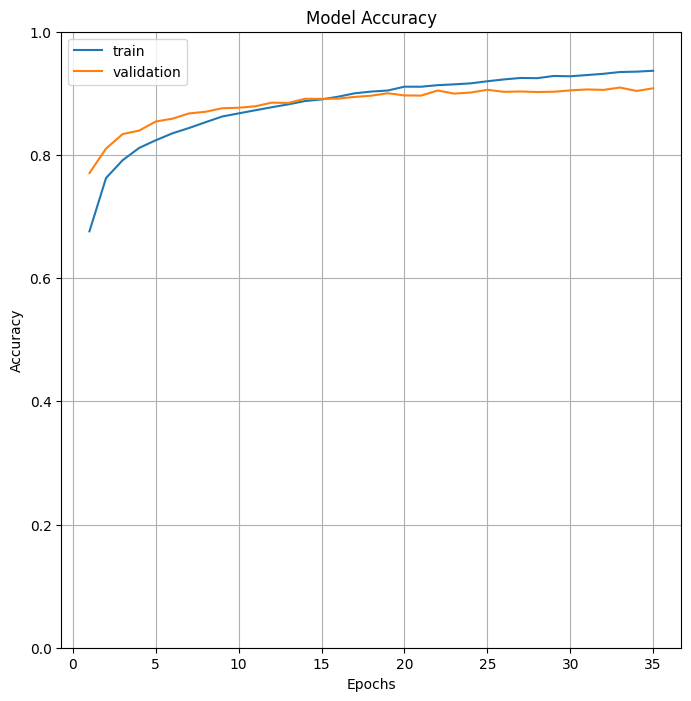

In [11]:
epochs_len = len(history['subCategory_output_accuracy'])
plt.figure(figsize=(8, 8))
epochs_range= range(1, epochs_len+1)
plt.plot(epochs_range, accuracy, label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

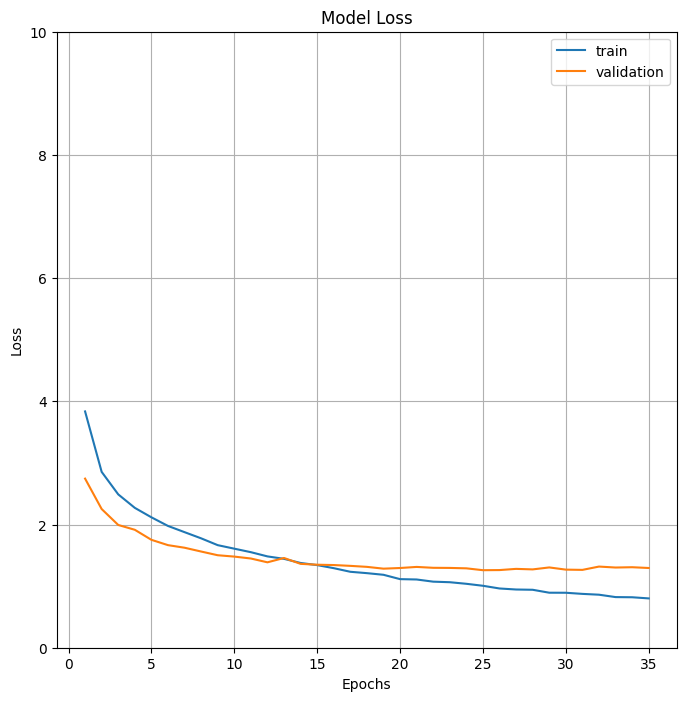

In [13]:
plt.figure(figsize=(8, 8))
epochs_range= range(1, epochs_len+1)
plt.plot(epochs_range, history['loss'], label="Training Loss")
plt.plot(epochs_range, history['val_loss'], label="Validation Loss")
plt.axis(ymin=0,ymax=10)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

## 8. ResNet50 Model Grayscale Images with Trainable Top Pre-Trained Layers

### Import the Pre-trained Model

In [40]:
def build_model():
    # Define image dimensions
    img_height, img_width = 224, 224

    # Use the ResNet50 pretrained model as the feature extractor
    resnet_model = resnet50.ResNet50(include_top=False,
                            input_shape=(img_height, img_width, 3),
                            pooling='avg',
                            weights='imagenet')

    # Fine-tune from this layer onwards
    fine_tune_at = 168

    # Freeze the layers of the ResNet50 model (176 layers) to use it as a feature extractor
    for layer in resnet_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Create the multi-output model
    inputs = Input(shape=(img_height, img_width, 3))
    x = resnet50.preprocess_input(inputs)
    x = Lambda(lambda img: tf.image.rgb_to_grayscale(img))(x)
    x = Lambda(lambda img: tf.image.grayscale_to_rgb(img))(x)
    x = resnet_model(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)  # Regularize with dropout
    x = Dense(512, activation='relu')(x)

    # Define the number of classes for each output column
    num_classes_articleType = len(df['articleType'].unique())
    num_classes_usage = len(df['usage'].unique())

    # Output layers for each output column
    subCategory_output = Dense(1, activation='sigmoid', name='subCategory_output')(x)
    articleType_output = Dense(num_classes_articleType, activation='softmax', name='articleType_output')(x)
    gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)
    season_output = Dense(1, activation='sigmoid', name='season_output')(x)
    usage_output = Dense(num_classes_usage, activation='softmax', name='usage_output')(x)

    # Create the model with multiple output layers
    model = Model(inputs=inputs, outputs=[subCategory_output, articleType_output, gender_output, season_output, usage_output])
    return model

In [41]:
model8 = build_model()
# Compile the model with appropriate loss functions for each output
model8.compile(optimizer=Adam(0.0001),
              loss={'subCategory_output': 'binary_crossentropy',
                    'articleType_output': 'sparse_categorical_crossentropy',
                    'gender_output': 'binary_crossentropy',
                    'season_output': 'binary_crossentropy',
                    'usage_output': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])
model8.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_3  (None, 224, 224, 3)          0         ['input_18[0][0]']            
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.nn.bias_add_3 (TFOpLamb  (None, 224, 224, 3)          0         ['tf.__operators__.getitem_3[0
 da)                                                                ][0]']                        
                                                                                            

### Train Model

In [42]:
epochs=100
initial_epoch=0
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            restore_best_weights=True)

checkpoint_filepath = '../models/ResNet50_train_top/weights.{epoch:03d}-{val_loss:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [33]:
history8 = model8.fit(train_generator, validation_data=validation_generator, epochs=epochs, initial_epoch=initial_epoch,
                    callbacks=[early_stopping_callback, model_checkpoint_callback])

Epoch 1/100
350/350 [==============================] - 319s 887ms/step - loss: 3.5405 - subCategory_output_loss: 0.1898 - articleType_output_loss: 1.6952 - gender_output_loss: 0.4624 - season_output_loss: 0.6677 - usage_output_loss: 0.5254 - subCategory_output_accuracy: 0.9287 - articleType_output_accuracy: 0.3994 - gender_output_accuracy: 0.7709 - season_output_accuracy: 0.5932 - usage_output_accuracy: 0.8062 - val_loss: 3.1780 - val_subCategory_output_loss: 0.1227 - val_articleType_output_loss: 1.4606 - val_gender_output_loss: 0.4703 - val_season_output_loss: 0.6648 - val_usage_output_loss: 0.4597 - val_subCategory_output_accuracy: 0.9629 - val_articleType_output_accuracy: 0.4900 - val_gender_output_accuracy: 0.7639 - val_season_output_accuracy: 0.6098 - val_usage_output_accuracy: 0.8238
Epoch 2/100
350/350 [==============================] - 265s 757ms/step - loss: 2.7096 - subCategory_output_loss: 0.0966 - articleType_output_loss: 1.2155 - gender_output_loss: 0.3386 - season_output_

In [43]:
model8.load_weights('../models/ResNet50_train_top/weights.003-2.61.hdf5')

### Training Visualization

In [34]:
# Combine the lists into a 2D array
accuracy_matrix = np.array([history8.history['subCategory_output_accuracy'],
                            history8.history['articleType_output_accuracy'],
                            history8.history['gender_output_accuracy'],
                            # history.history['baseColour_output_accuracy'],
                            history8.history['season_output_accuracy'],
                            history8.history['usage_output_accuracy']])

# Calculate the average for each position (across all lists)
accuracy = np.mean(accuracy_matrix, axis=0)

In [35]:
# Combine the lists into a 2D array
val_accuracy_matrix = np.array([history8.history['val_subCategory_output_accuracy'],
                            history8.history['val_articleType_output_accuracy'],
                            history8.history['val_gender_output_accuracy'],
                            # history2.history['val_baseColour_output_accuracy'],
                            history8.history['val_season_output_accuracy'],
                            history8.history['val_usage_output_accuracy']])

# Calculate the average for each position (across all lists)
val_accuracy = np.mean(val_accuracy_matrix, axis=0)

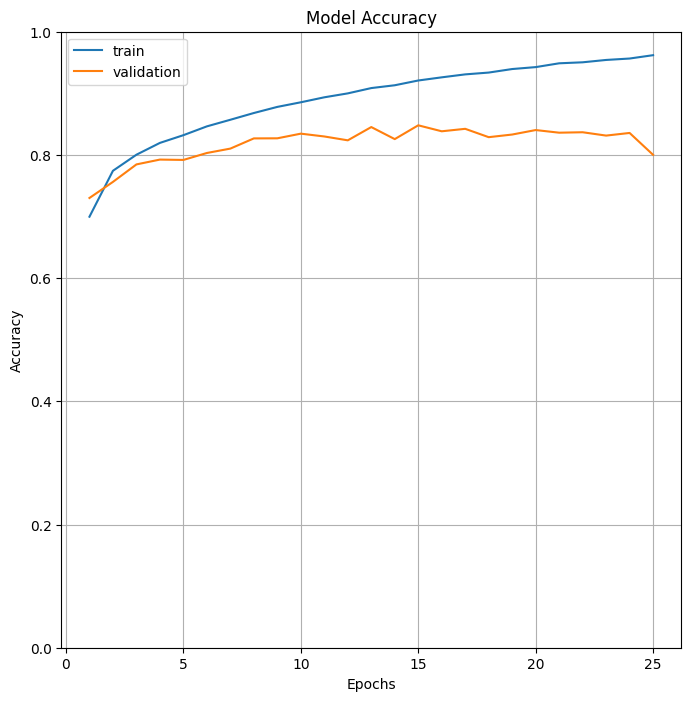

In [36]:
epochs_len = len(history8.history['subCategory_output_accuracy'])
plt.figure(figsize=(8, 8))
epochs_range= range(initial_epoch+1, epochs_len+1)
plt.plot(epochs_range, accuracy, label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

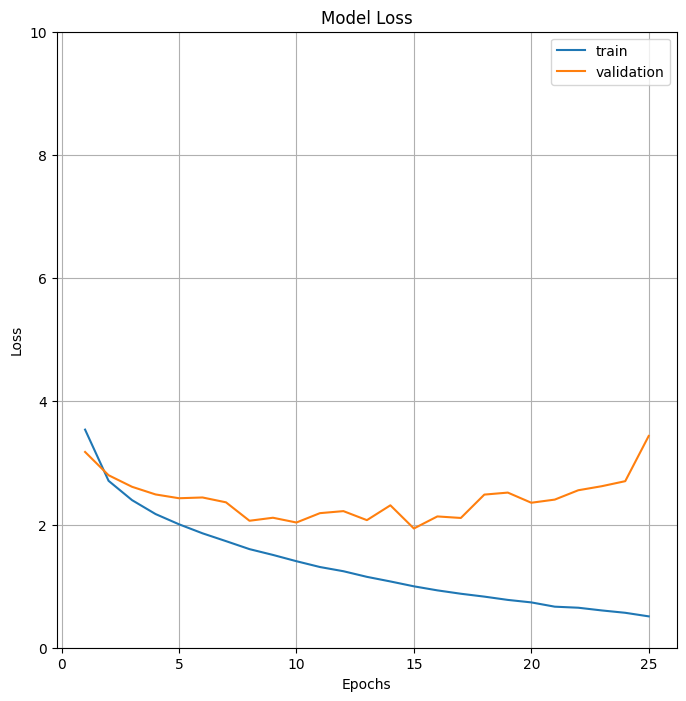

In [37]:
plt.figure(figsize=(8, 8))
epochs_range= range(initial_epoch+1, epochs_len+1)
plt.plot( epochs_range, history8.history['loss'], label="Training Loss")
plt.plot(epochs_range, history8.history['val_loss'], label="Validation Loss")
plt.axis(ymin=0,ymax=10)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

# Models Evaluation

## Get Labels

In [47]:
# Create a DataFrame to store the encoded values and their corresponding labels
subCategory_labels = df[['subCategory_enc', 'subCategory']].drop_duplicates().\
    sort_values(by='subCategory_enc')['subCategory'].tolist()
articleType_labels = df[['articleType_enc', 'articleType']].drop_duplicates().\
    sort_values(by='articleType_enc')['articleType'].tolist()
gender_labels = df[['gender_enc', 'gender']].drop_duplicates().\
    sort_values(by='gender_enc')['gender'].tolist()
season_labels = df[['season_enc', 'season']].drop_duplicates().\
    sort_values(by='season_enc')['season'].tolist()
usage_labels = df[['usage_enc', 'usage']].drop_duplicates().\
    sort_values(by='usage_enc')['usage'].tolist()

target_names = [subCategory_labels, articleType_labels, gender_labels, season_labels, usage_labels]

# Print the result
print(target_names)

[['Bottomwear', 'Topwear'], ['Capris', 'Jackets', 'Jeans', 'Leggings', 'Shirts', 'Shorts', 'Skirts', 'Sweaters', 'Sweatshirts', 'Tops', 'Track Pants', 'Trousers', 'Tshirts', 'Tunics'], ['Men', 'Women'], ['Fall/Winter', 'Spring/Summer'], ['Casual', 'Formal', 'Sports']]


## Define Evaluation Function

In [61]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


def create_evaluation(model, test_generator, target_names):
    output = ["SubCategory", "ArticleType", "Gender", "Season", "Usage"]
    y_pred = model.predict(test_generator)
    y_true = test_generator.labels
    for i, y_pred_output in enumerate(y_pred):
        y_true_output = y_true[i]  # Get the corresponding true labels for this output
        if y_pred_output.shape[1] == 1:
            y_pred_labels = (np.squeeze(y_pred_output) >= 0.5).astype(int)
        else:
            y_pred_labels = np.argmax(y_pred_output, axis=1)  # Convert predicted probabilities to labels
        # Confusion Matrix
        # Generate confusion matrix
        cm = confusion_matrix(y_true_output, y_pred_labels)
        # Plot confusion matrix using seaborn heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names[i], yticklabels=target_names[i])
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(output[i] + " Confusion Matrix")
        plt.show()
        # Classification Report
        print(output[i], "Classification Report:\n")
        # Print classification report for this output
        print(classification_report(y_true_output, y_pred_labels, labels=np.unique(y_true_output), 
                                    target_names=target_names[i], zero_division=0))
        # ROC Curve - AUC
        fig = go.Figure()
        if len(y_pred_output) == len(y_pred_output.reshape(-1)):
            # Reshape y_pred_output to match the shape of y_true_output
            y_pred_output = y_pred_output.reshape(-1)  # Flatten to 1D array
            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y_true_output, y_pred_output)
            roc_auc = auc(fpr, tpr)
            # Plot ROC curve
            fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (AUC = {roc_auc:.2f})'))
        else:  # Multiclass case
            # Calculate ROC curve for each class in the current output
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            for class_idx in range(len(target_names[i])):
                fpr[class_idx], tpr[class_idx], _ = roc_curve(y_true_output == class_idx, y_pred_output[:, class_idx])
                roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])
            # Plot ROC curves for each class
            for class_idx in range(len(target_names[i])):
                fig.add_trace(go.Scatter(x=fpr[class_idx], y=tpr[class_idx], mode='lines',
                                        name=f'{target_names[i][class_idx]} (AUC = {roc_auc[class_idx]:.2f})'))
        fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash', color="black"), name='Random Guess'))
        fig.update_layout(
            title=f'{output[i]} ROC Curve',
            xaxis_title='False Positive Rate',
            yaxis_title='True Positive Rate',
            xaxis=dict(range=[0, 1]),
            yaxis=dict(range=[0, 1]),
            legend=dict(x=1, y=0, traceorder='normal'),
            plot_bgcolor='#F4F5F3',
        )
        fig.show()

## Evaluate 1st Model (EfficientNetv2-S Model with Reduce LR)

44/44 [==============================] - 100s 2s/step


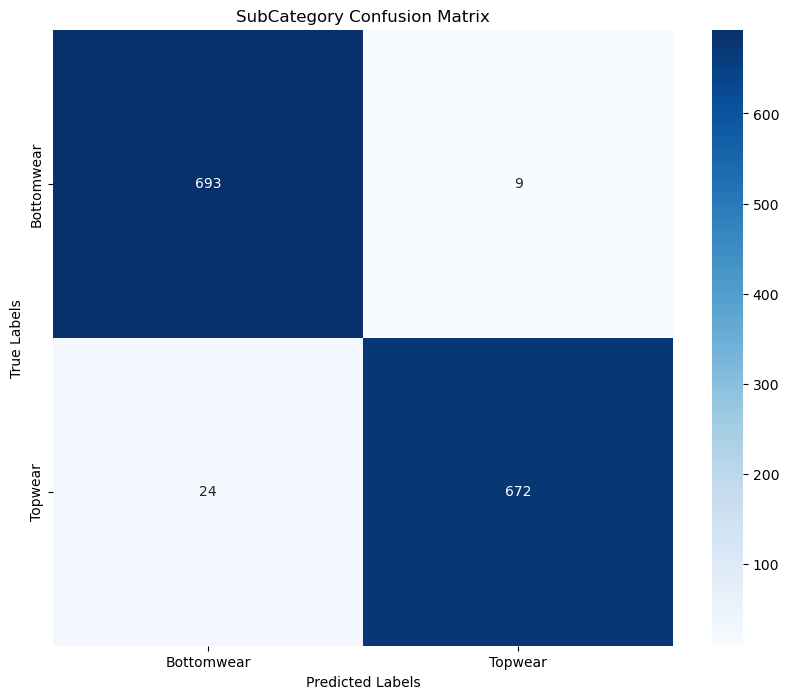

SubCategory Classification Report:

              precision    recall  f1-score   support

  Bottomwear       0.97      0.99      0.98       702
     Topwear       0.99      0.97      0.98       696

    accuracy                           0.98      1398
   macro avg       0.98      0.98      0.98      1398
weighted avg       0.98      0.98      0.98      1398



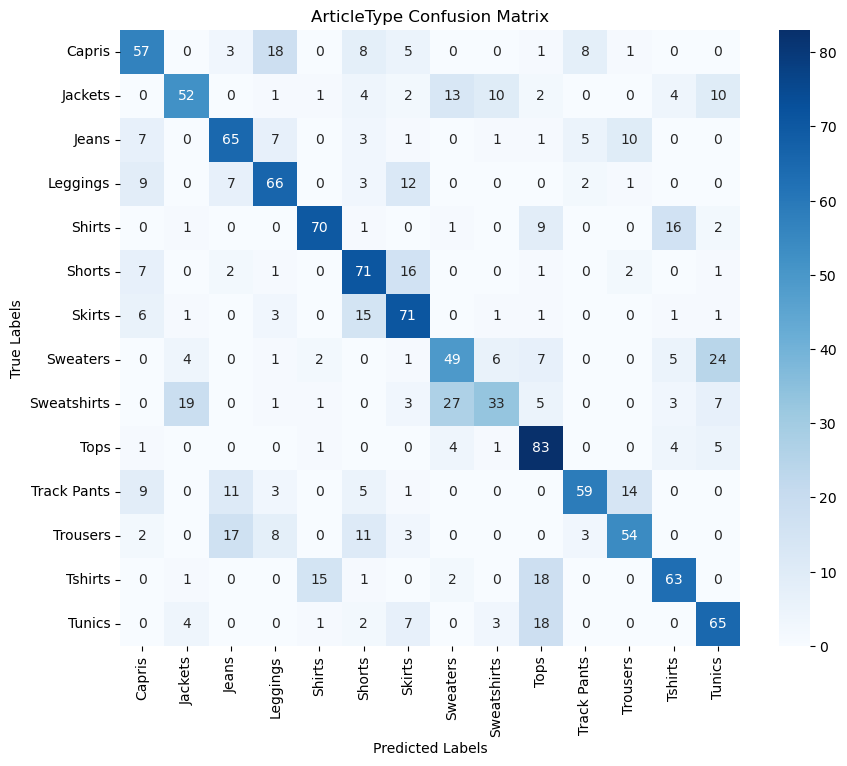

ArticleType Classification Report:

              precision    recall  f1-score   support

      Capris       0.58      0.56      0.57       101
     Jackets       0.63      0.53      0.57        99
       Jeans       0.62      0.65      0.63       100
    Leggings       0.61      0.66      0.63       100
      Shirts       0.77      0.70      0.73       100
      Shorts       0.57      0.70      0.63       101
      Skirts       0.58      0.71      0.64       100
    Sweaters       0.51      0.49      0.50        99
 Sweatshirts       0.60      0.33      0.43        99
        Tops       0.57      0.84      0.68        99
 Track Pants       0.77      0.58      0.66       102
    Trousers       0.66      0.55      0.60        98
     Tshirts       0.66      0.63      0.64       100
      Tunics       0.57      0.65      0.60       100

    accuracy                           0.61      1398
   macro avg       0.62      0.61      0.61      1398
weighted avg       0.62      0.61      0.61 

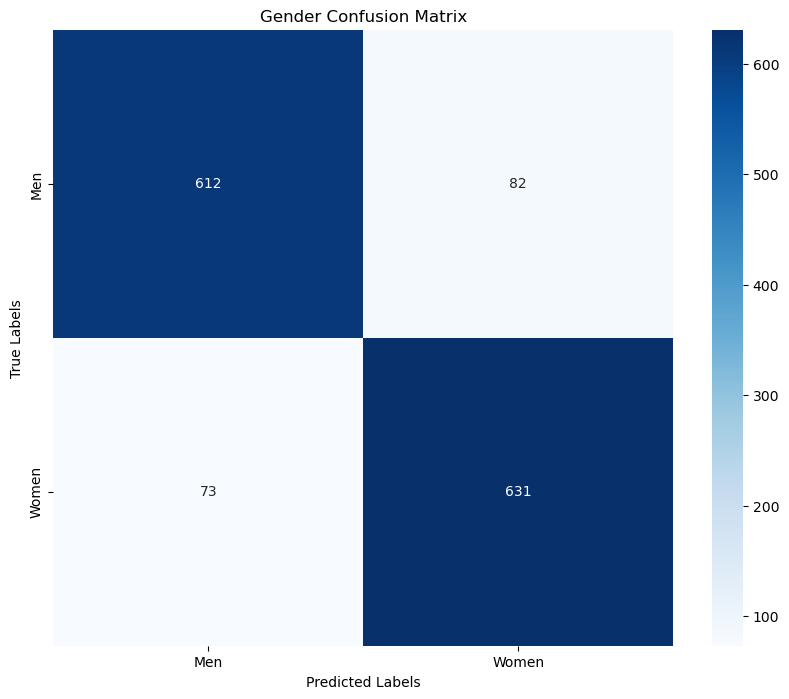

Gender Classification Report:

              precision    recall  f1-score   support

         Men       0.89      0.88      0.89       694
       Women       0.88      0.90      0.89       704

    accuracy                           0.89      1398
   macro avg       0.89      0.89      0.89      1398
weighted avg       0.89      0.89      0.89      1398



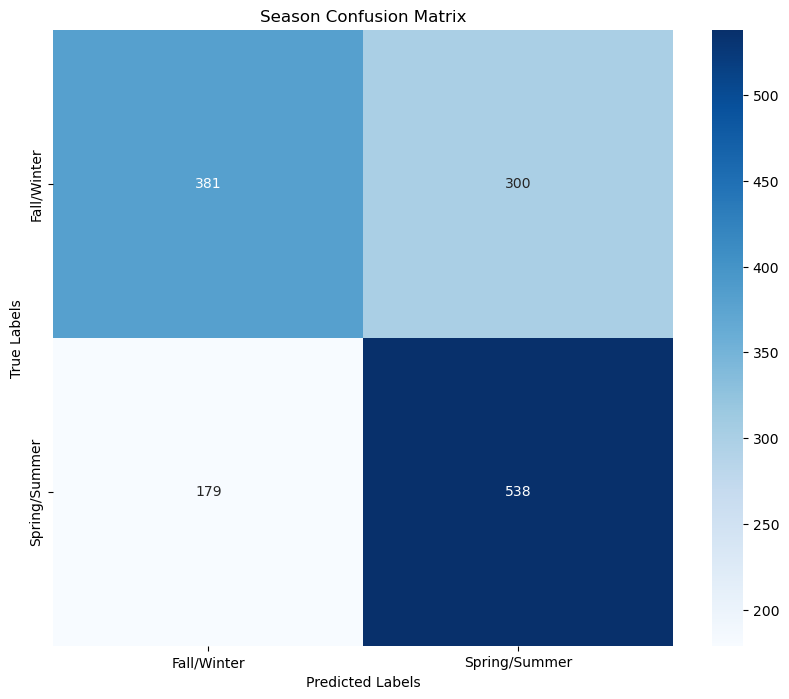

Season Classification Report:

               precision    recall  f1-score   support

  Fall/Winter       0.68      0.56      0.61       681
Spring/Summer       0.64      0.75      0.69       717

     accuracy                           0.66      1398
    macro avg       0.66      0.65      0.65      1398
 weighted avg       0.66      0.66      0.65      1398



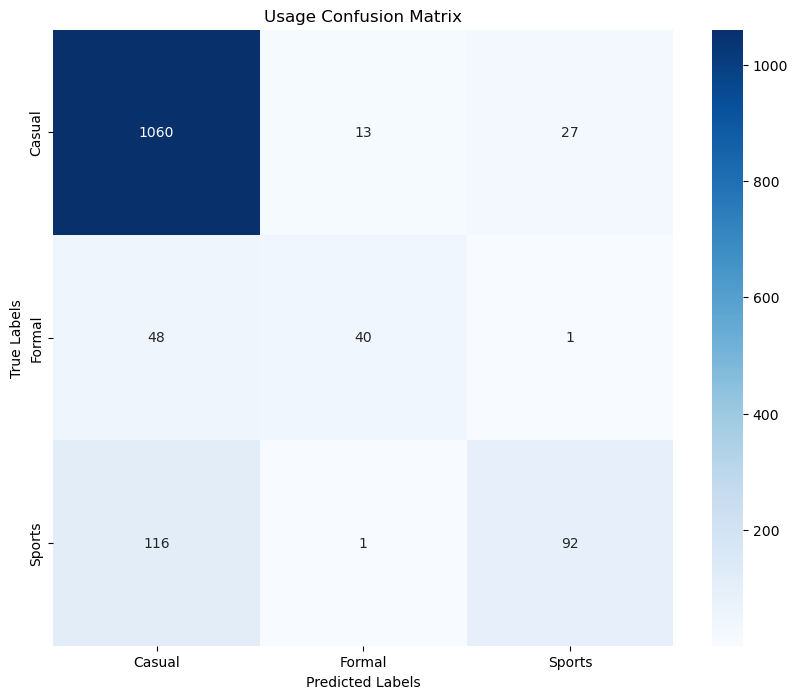

Usage Classification Report:

              precision    recall  f1-score   support

      Casual       0.87      0.96      0.91      1100
      Formal       0.74      0.45      0.56        89
      Sports       0.77      0.44      0.56       209

    accuracy                           0.85      1398
   macro avg       0.79      0.62      0.68      1398
weighted avg       0.84      0.85      0.84      1398



In [62]:
create_evaluation(model, test_generator, target_names)

## Evaluate 2nd Model (ResNet50 Model with Reduce LR)

44/44 [==============================] - 91s 2s/step


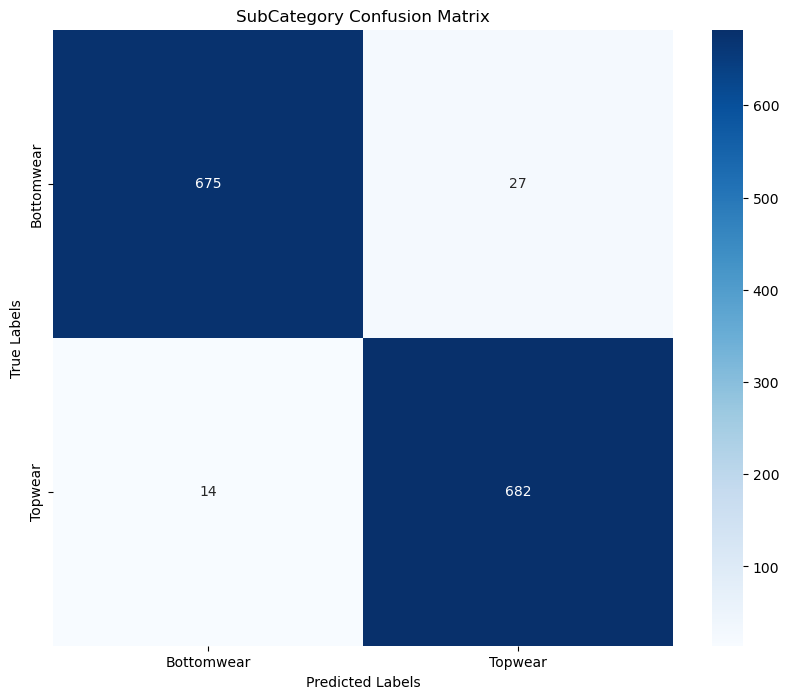

SubCategory Classification Report:

              precision    recall  f1-score   support

  Bottomwear       0.98      0.96      0.97       702
     Topwear       0.96      0.98      0.97       696

    accuracy                           0.97      1398
   macro avg       0.97      0.97      0.97      1398
weighted avg       0.97      0.97      0.97      1398



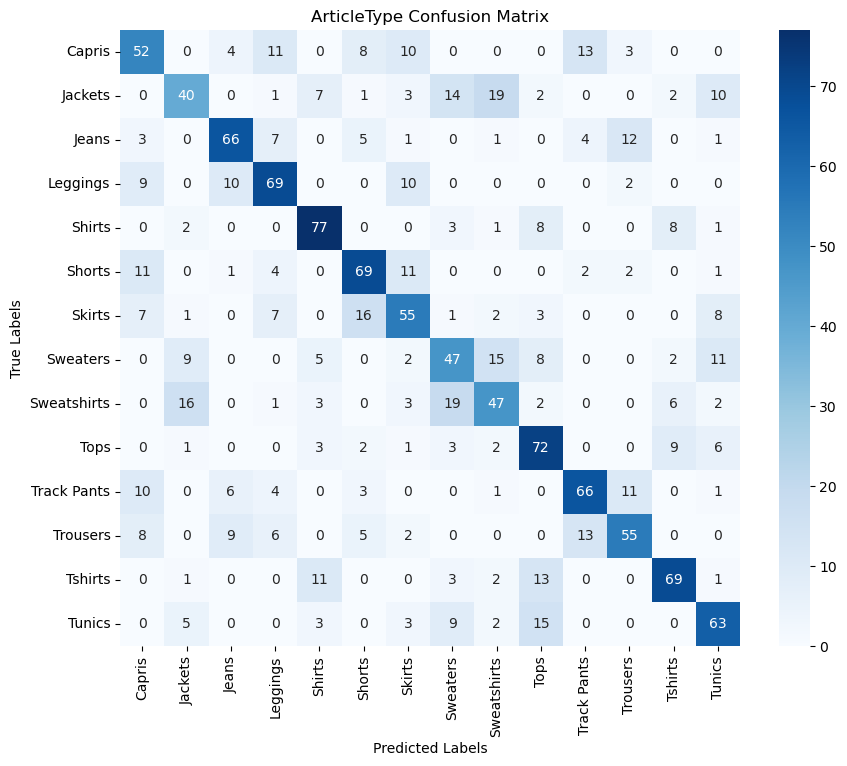

ArticleType Classification Report:

              precision    recall  f1-score   support

      Capris       0.52      0.51      0.52       101
     Jackets       0.53      0.40      0.46        99
       Jeans       0.69      0.66      0.67       100
    Leggings       0.63      0.69      0.66       100
      Shirts       0.71      0.77      0.74       100
      Shorts       0.63      0.68      0.66       101
      Skirts       0.54      0.55      0.55       100
    Sweaters       0.47      0.47      0.47        99
 Sweatshirts       0.51      0.47      0.49        99
        Tops       0.59      0.73      0.65        99
 Track Pants       0.67      0.65      0.66       102
    Trousers       0.65      0.56      0.60        98
     Tshirts       0.72      0.69      0.70       100
      Tunics       0.60      0.63      0.61       100

    accuracy                           0.61      1398
   macro avg       0.60      0.61      0.60      1398
weighted avg       0.60      0.61      0.60 

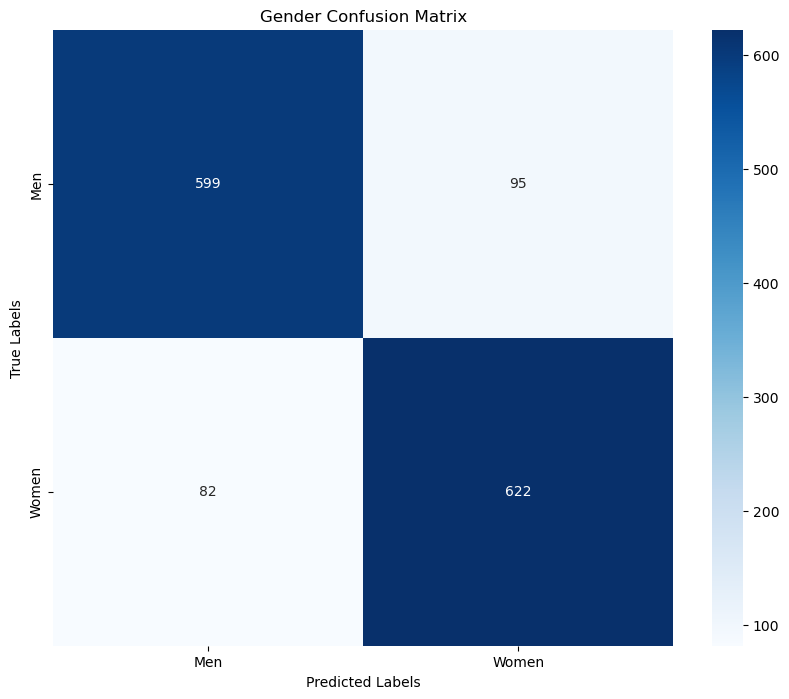

Gender Classification Report:

              precision    recall  f1-score   support

         Men       0.88      0.86      0.87       694
       Women       0.87      0.88      0.88       704

    accuracy                           0.87      1398
   macro avg       0.87      0.87      0.87      1398
weighted avg       0.87      0.87      0.87      1398



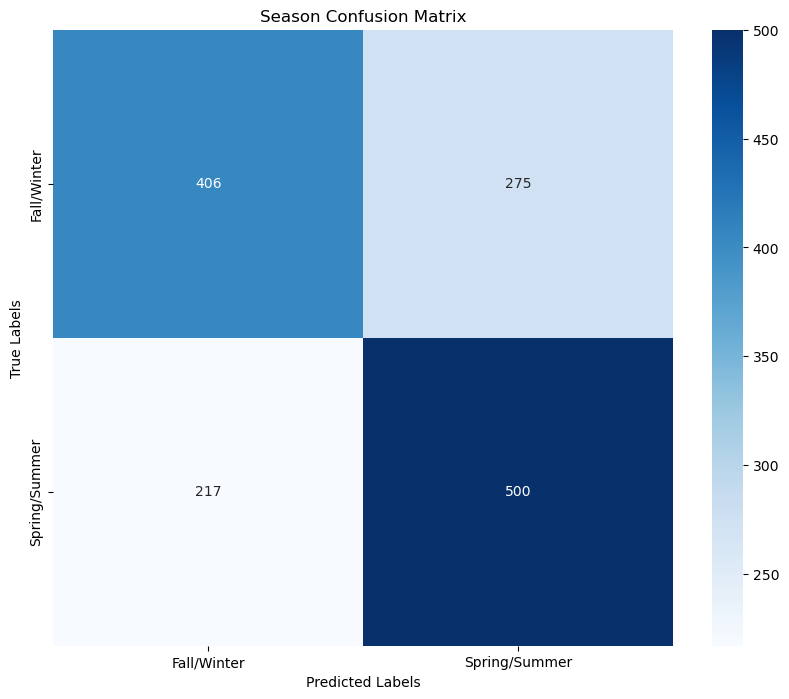

Season Classification Report:

               precision    recall  f1-score   support

  Fall/Winter       0.65      0.60      0.62       681
Spring/Summer       0.65      0.70      0.67       717

     accuracy                           0.65      1398
    macro avg       0.65      0.65      0.65      1398
 weighted avg       0.65      0.65      0.65      1398



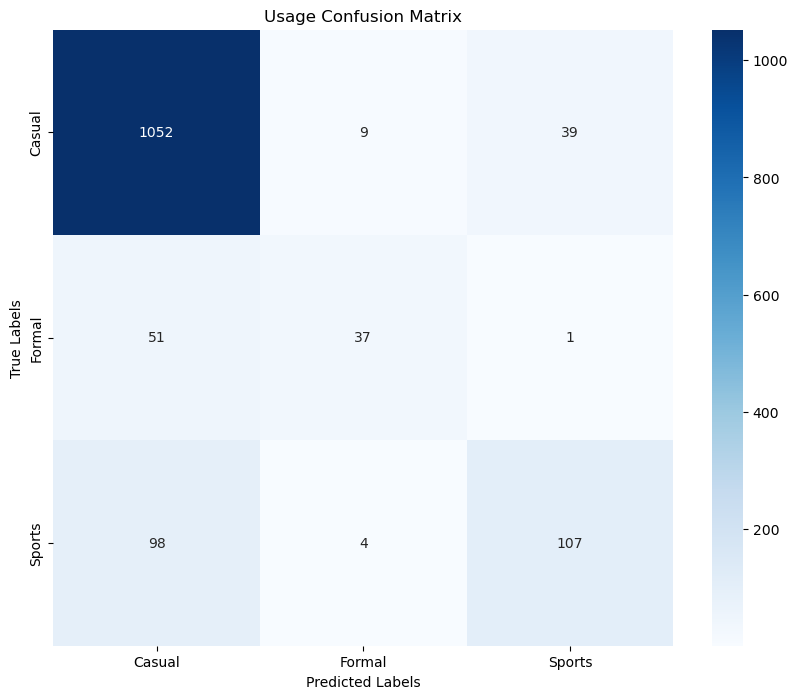

Usage Classification Report:

              precision    recall  f1-score   support

      Casual       0.88      0.96      0.91      1100
      Formal       0.74      0.42      0.53        89
      Sports       0.73      0.51      0.60       209

    accuracy                           0.86      1398
   macro avg       0.78      0.63      0.68      1398
weighted avg       0.85      0.86      0.84      1398



In [63]:
create_evaluation(model2, test_generator, target_names)

## Evaluate 3rd Model (EfficientNetv2-S Model without changing LR)

44/44 [==============================] - 97s 2s/step


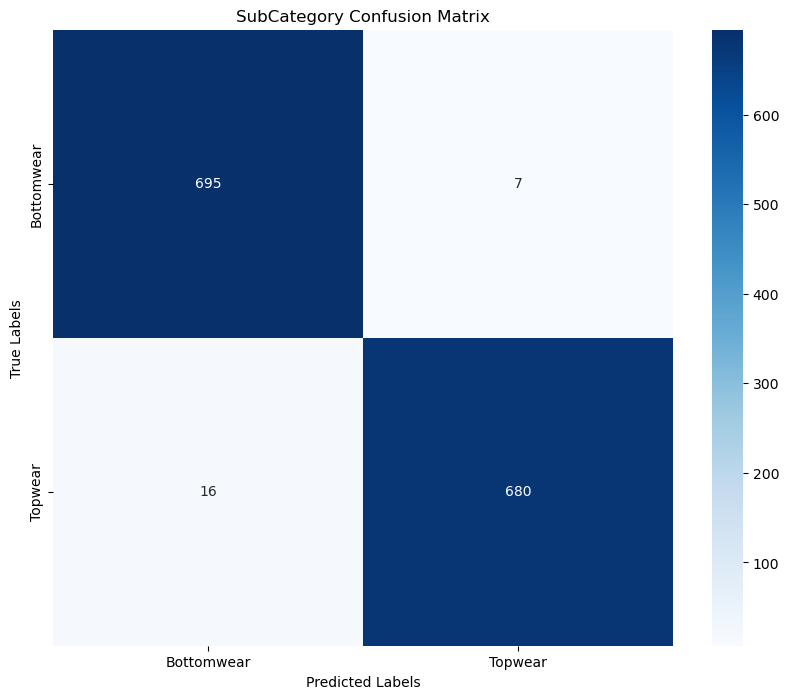

SubCategory Classification Report:

              precision    recall  f1-score   support

  Bottomwear       0.98      0.99      0.98       702
     Topwear       0.99      0.98      0.98       696

    accuracy                           0.98      1398
   macro avg       0.98      0.98      0.98      1398
weighted avg       0.98      0.98      0.98      1398



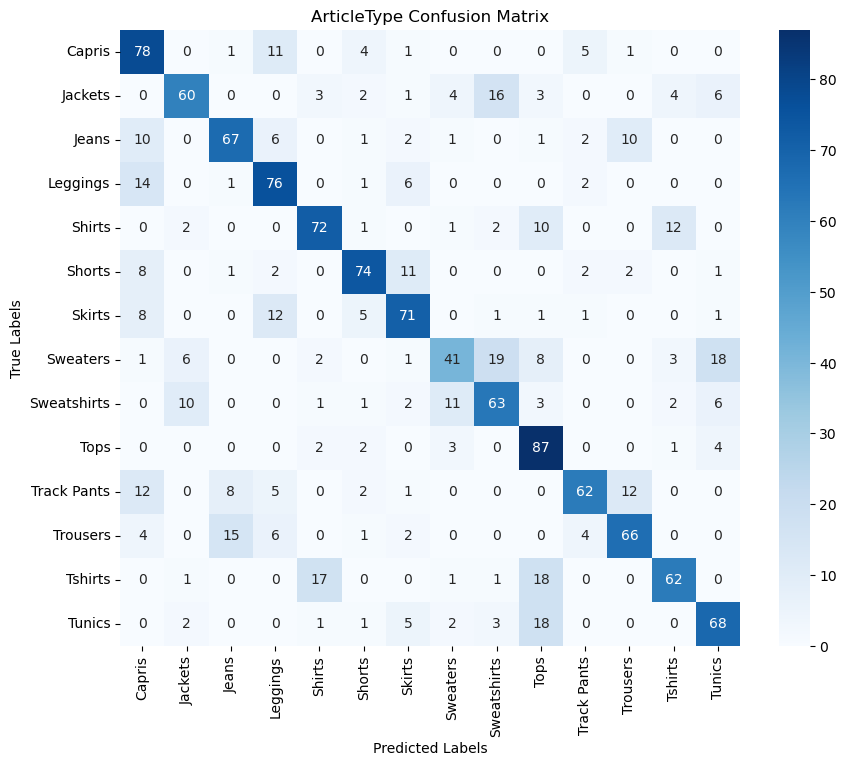

ArticleType Classification Report:

              precision    recall  f1-score   support

      Capris       0.58      0.77      0.66       101
     Jackets       0.74      0.61      0.67        99
       Jeans       0.72      0.67      0.69       100
    Leggings       0.64      0.76      0.70       100
      Shirts       0.73      0.72      0.73       100
      Shorts       0.78      0.73      0.76       101
      Skirts       0.69      0.71      0.70       100
    Sweaters       0.64      0.41      0.50        99
 Sweatshirts       0.60      0.64      0.62        99
        Tops       0.58      0.88      0.70        99
 Track Pants       0.79      0.61      0.69       102
    Trousers       0.73      0.67      0.70        98
     Tshirts       0.74      0.62      0.67       100
      Tunics       0.65      0.68      0.67       100

    accuracy                           0.68      1398
   macro avg       0.69      0.68      0.68      1398
weighted avg       0.69      0.68      0.68 

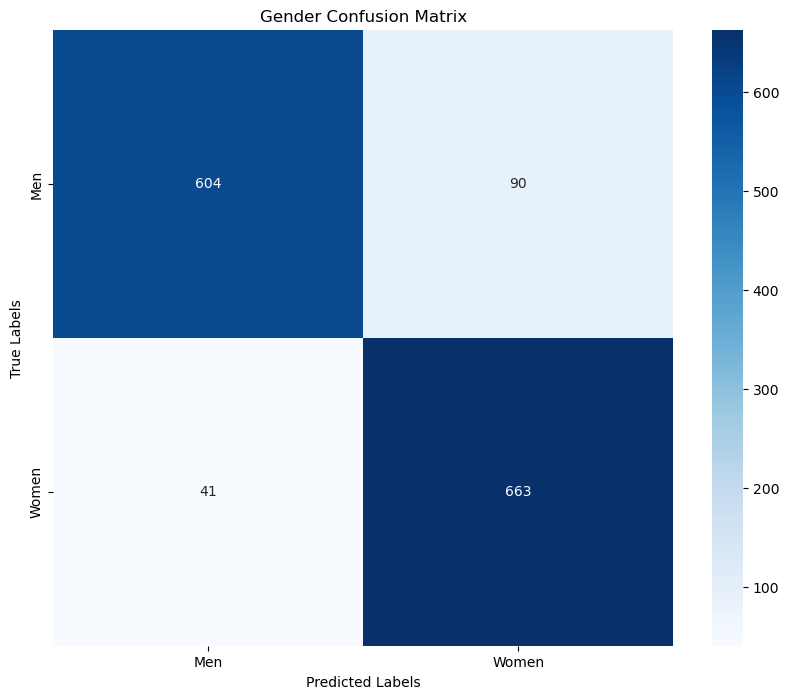

Gender Classification Report:

              precision    recall  f1-score   support

         Men       0.94      0.87      0.90       694
       Women       0.88      0.94      0.91       704

    accuracy                           0.91      1398
   macro avg       0.91      0.91      0.91      1398
weighted avg       0.91      0.91      0.91      1398



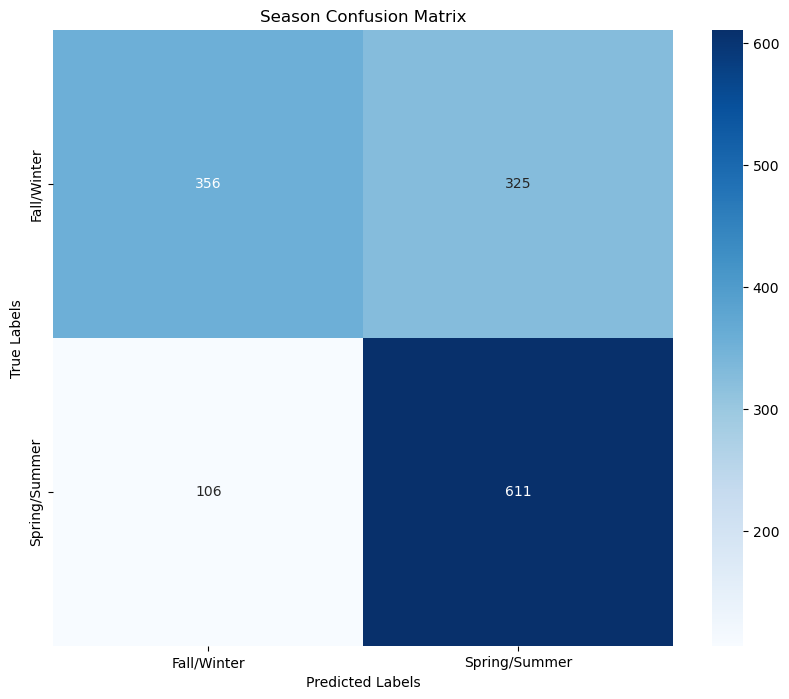

Season Classification Report:

               precision    recall  f1-score   support

  Fall/Winter       0.77      0.52      0.62       681
Spring/Summer       0.65      0.85      0.74       717

     accuracy                           0.69      1398
    macro avg       0.71      0.69      0.68      1398
 weighted avg       0.71      0.69      0.68      1398



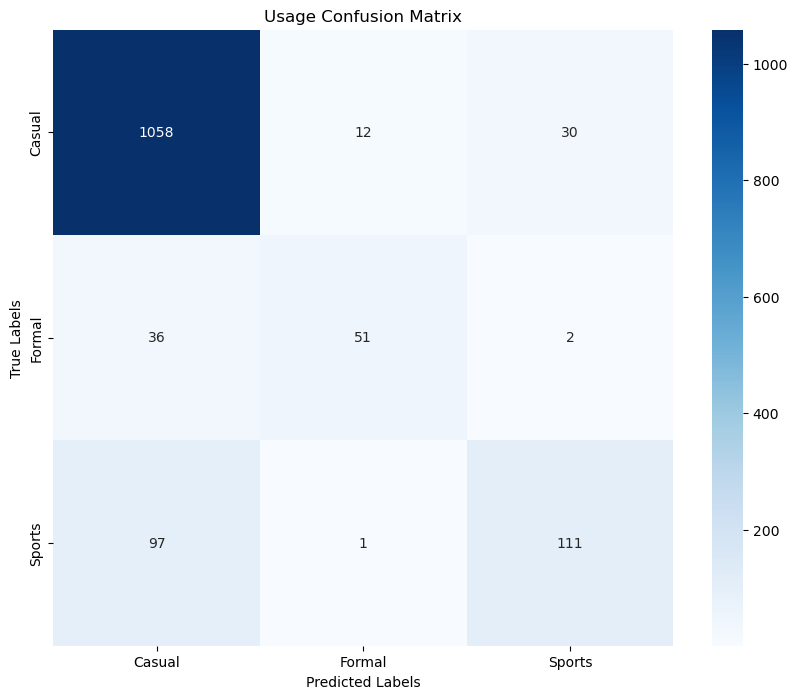

Usage Classification Report:

              precision    recall  f1-score   support

      Casual       0.89      0.96      0.92      1100
      Formal       0.80      0.57      0.67        89
      Sports       0.78      0.53      0.63       209

    accuracy                           0.87      1398
   macro avg       0.82      0.69      0.74      1398
weighted avg       0.87      0.87      0.86      1398



In [64]:
create_evaluation(model3, test_generator, target_names)

## Evaluate 4th Model (ResNet50 Model without changing LR)

44/44 [==============================] - 93s 2s/step


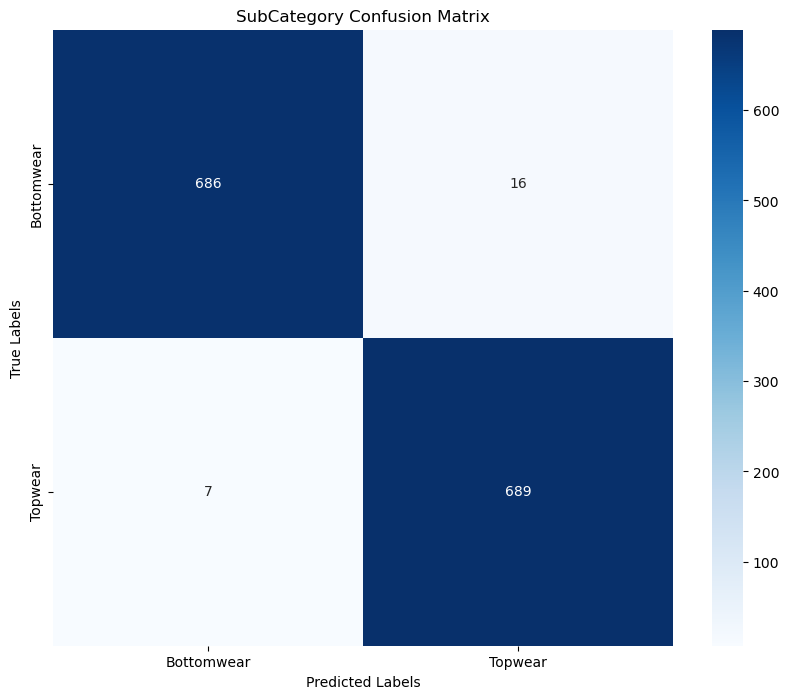

SubCategory Classification Report:

              precision    recall  f1-score   support

  Bottomwear       0.99      0.98      0.98       702
     Topwear       0.98      0.99      0.98       696

    accuracy                           0.98      1398
   macro avg       0.98      0.98      0.98      1398
weighted avg       0.98      0.98      0.98      1398



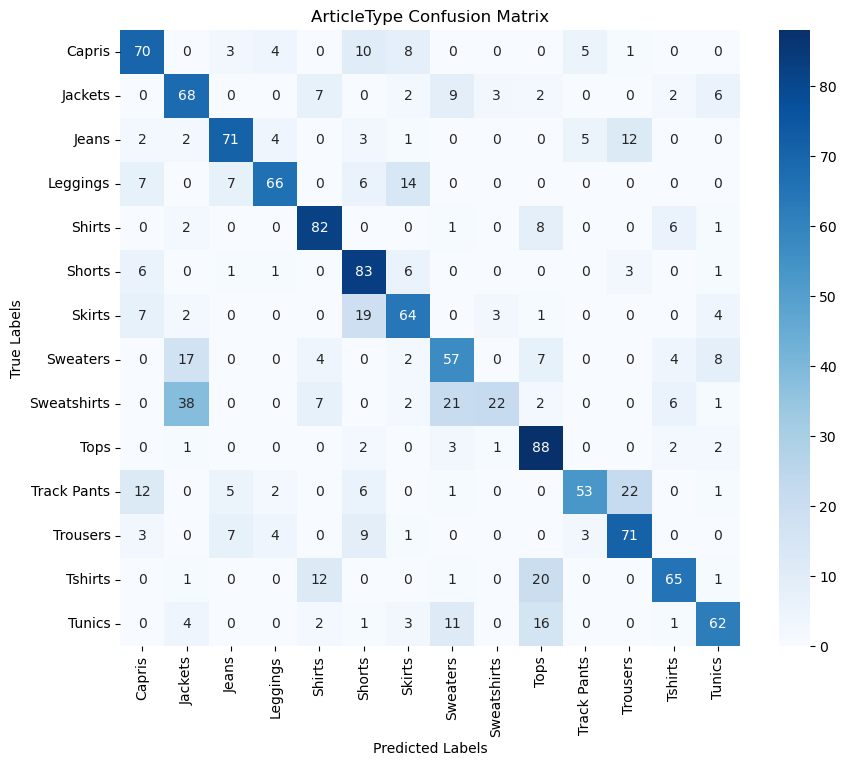

ArticleType Classification Report:

              precision    recall  f1-score   support

      Capris       0.65      0.69      0.67       101
     Jackets       0.50      0.69      0.58        99
       Jeans       0.76      0.71      0.73       100
    Leggings       0.81      0.66      0.73       100
      Shirts       0.72      0.82      0.77       100
      Shorts       0.60      0.82      0.69       101
      Skirts       0.62      0.64      0.63       100
    Sweaters       0.55      0.58      0.56        99
 Sweatshirts       0.76      0.22      0.34        99
        Tops       0.61      0.89      0.72        99
 Track Pants       0.80      0.52      0.63       102
    Trousers       0.65      0.72      0.69        98
     Tshirts       0.76      0.65      0.70       100
      Tunics       0.71      0.62      0.66       100

    accuracy                           0.66      1398
   macro avg       0.68      0.66      0.65      1398
weighted avg       0.68      0.66      0.65 

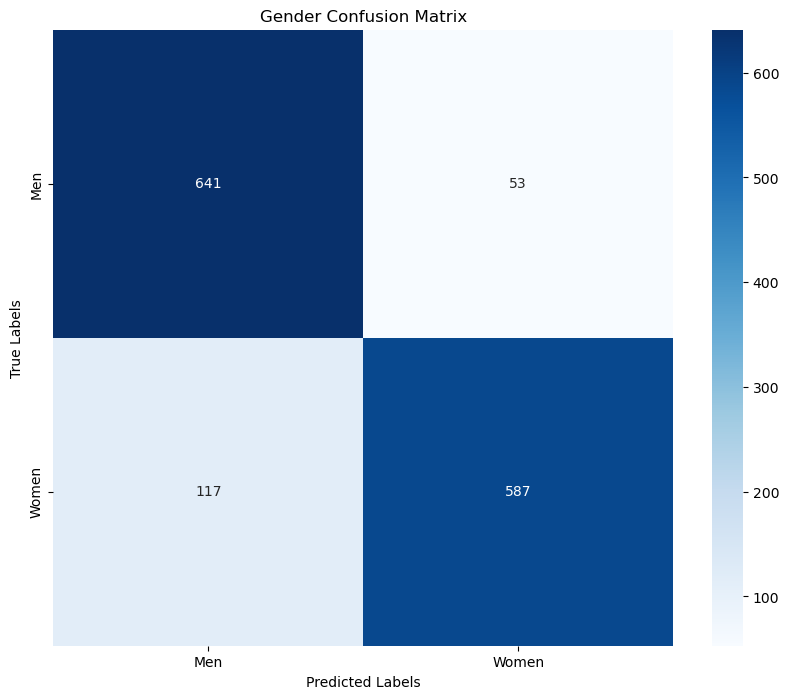

Gender Classification Report:

              precision    recall  f1-score   support

         Men       0.85      0.92      0.88       694
       Women       0.92      0.83      0.87       704

    accuracy                           0.88      1398
   macro avg       0.88      0.88      0.88      1398
weighted avg       0.88      0.88      0.88      1398



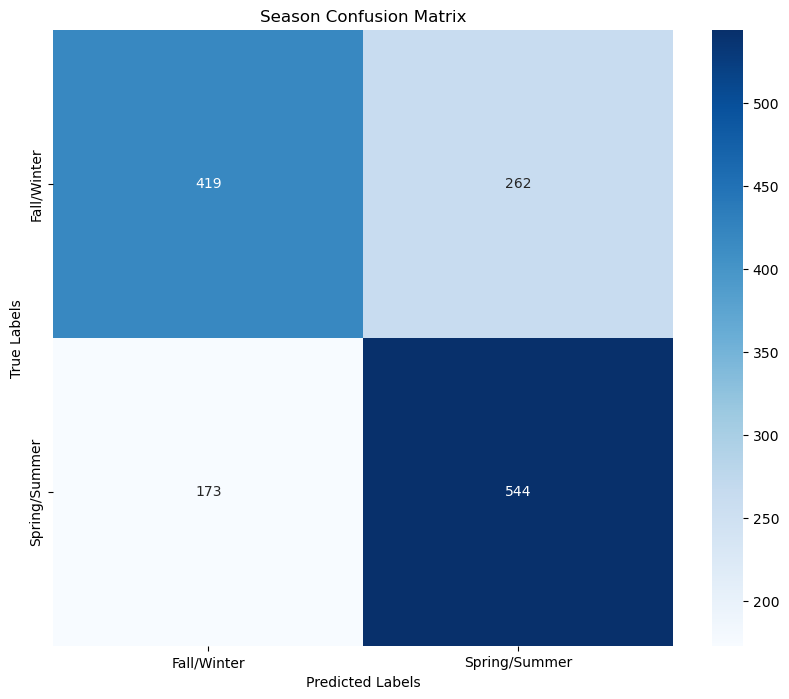

Season Classification Report:

               precision    recall  f1-score   support

  Fall/Winter       0.71      0.62      0.66       681
Spring/Summer       0.67      0.76      0.71       717

     accuracy                           0.69      1398
    macro avg       0.69      0.69      0.69      1398
 weighted avg       0.69      0.69      0.69      1398



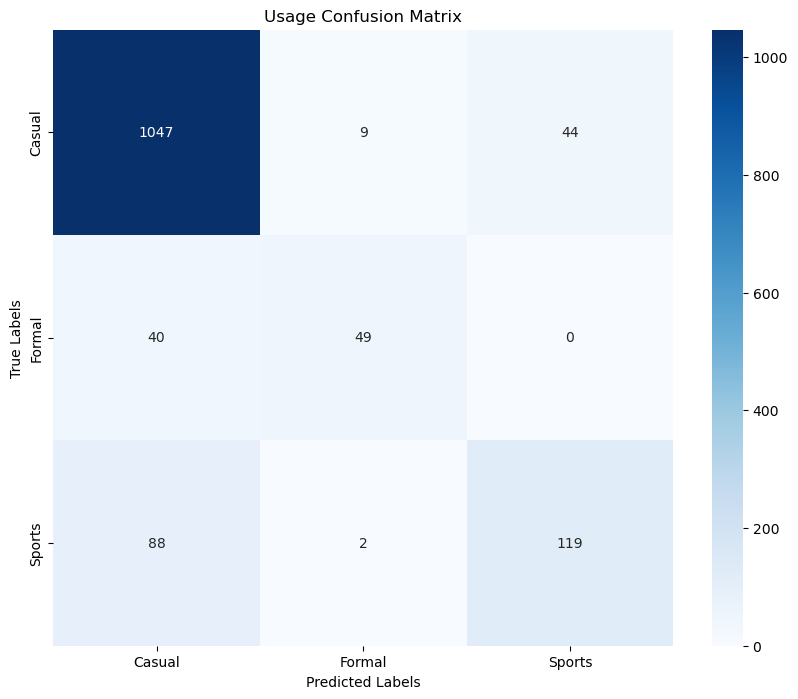

Usage Classification Report:

              precision    recall  f1-score   support

      Casual       0.89      0.95      0.92      1100
      Formal       0.82      0.55      0.66        89
      Sports       0.73      0.57      0.64       209

    accuracy                           0.87      1398
   macro avg       0.81      0.69      0.74      1398
weighted avg       0.86      0.87      0.86      1398



In [65]:
create_evaluation(model4, test_generator, target_names)

## Evaluate 5th Model (EfficientNetv2-S Model Grayscale Images)

44/44 [==============================] - 99s 2s/step


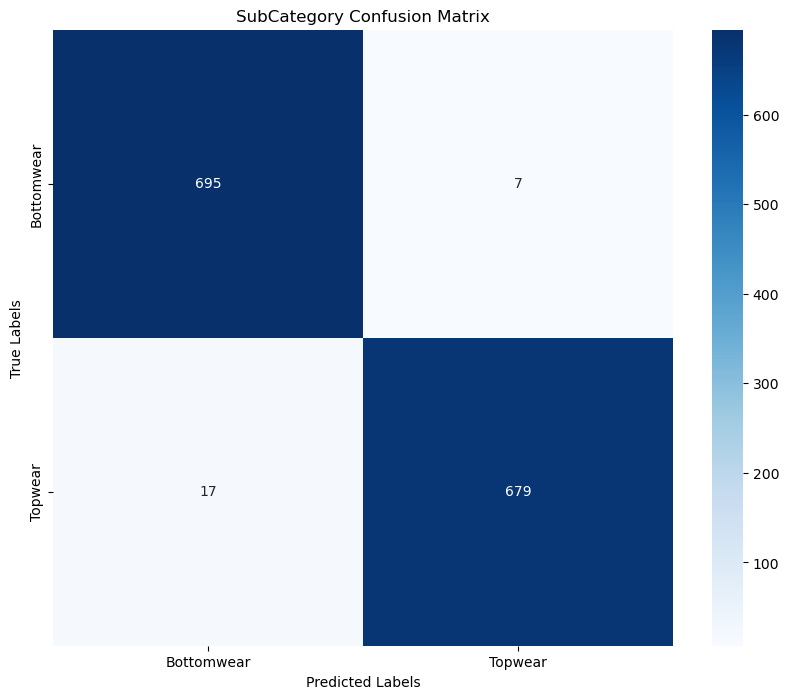

SubCategory Classification Report:

              precision    recall  f1-score   support

  Bottomwear       0.98      0.99      0.98       702
     Topwear       0.99      0.98      0.98       696

    accuracy                           0.98      1398
   macro avg       0.98      0.98      0.98      1398
weighted avg       0.98      0.98      0.98      1398



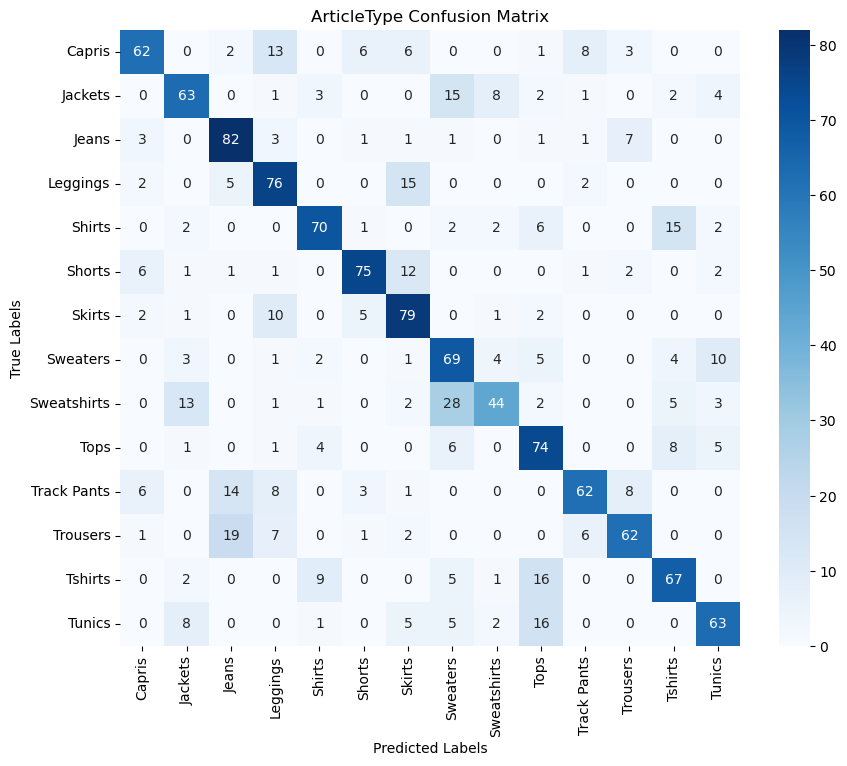

ArticleType Classification Report:

              precision    recall  f1-score   support

      Capris       0.76      0.61      0.68       101
     Jackets       0.67      0.64      0.65        99
       Jeans       0.67      0.82      0.74       100
    Leggings       0.62      0.76      0.68       100
      Shirts       0.78      0.70      0.74       100
      Shorts       0.82      0.74      0.78       101
      Skirts       0.64      0.79      0.71       100
    Sweaters       0.53      0.70      0.60        99
 Sweatshirts       0.71      0.44      0.55        99
        Tops       0.59      0.75      0.66        99
 Track Pants       0.77      0.61      0.68       102
    Trousers       0.76      0.63      0.69        98
     Tshirts       0.66      0.67      0.67       100
      Tunics       0.71      0.63      0.67       100

    accuracy                           0.68      1398
   macro avg       0.69      0.68      0.68      1398
weighted avg       0.69      0.68      0.68 

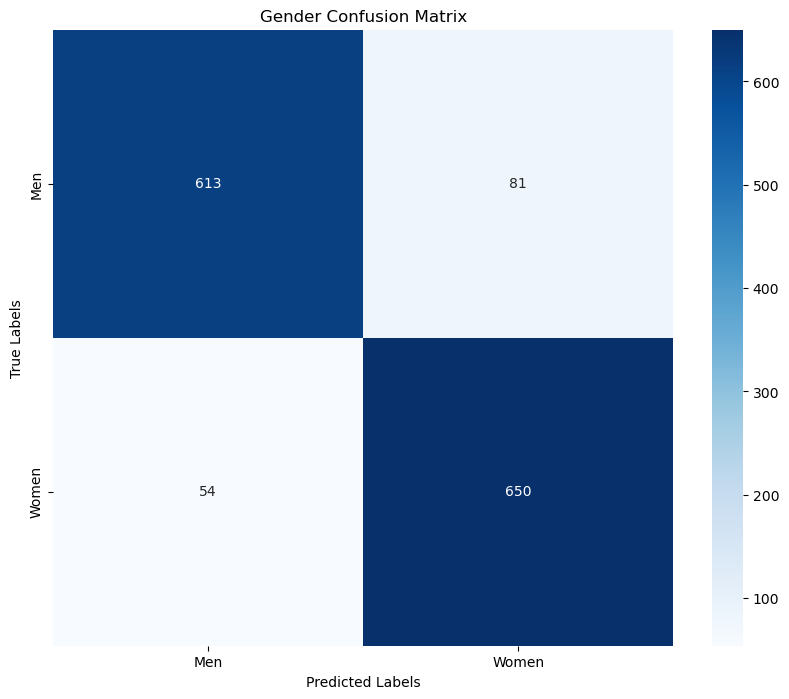

Gender Classification Report:

              precision    recall  f1-score   support

         Men       0.92      0.88      0.90       694
       Women       0.89      0.92      0.91       704

    accuracy                           0.90      1398
   macro avg       0.90      0.90      0.90      1398
weighted avg       0.90      0.90      0.90      1398



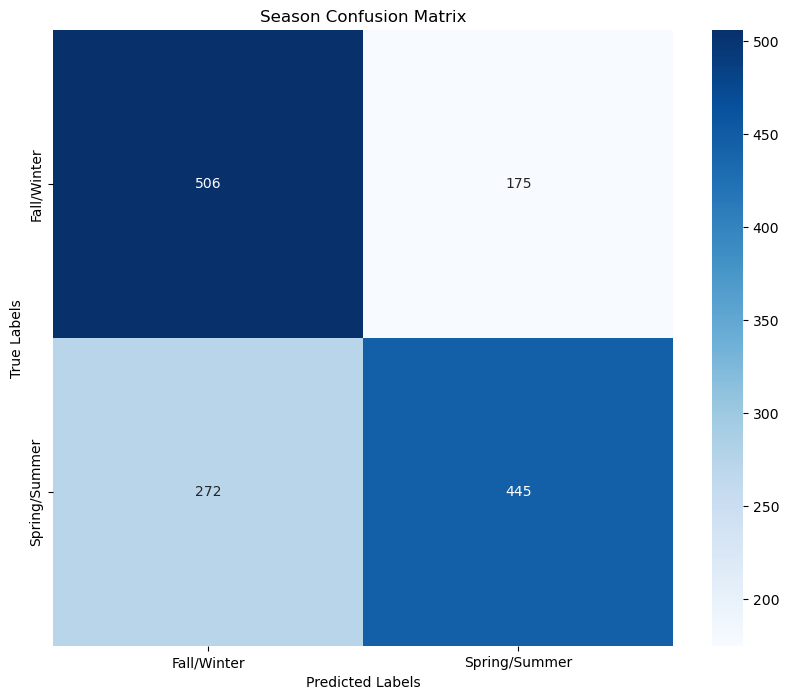

Season Classification Report:

               precision    recall  f1-score   support

  Fall/Winter       0.65      0.74      0.69       681
Spring/Summer       0.72      0.62      0.67       717

     accuracy                           0.68      1398
    macro avg       0.68      0.68      0.68      1398
 weighted avg       0.68      0.68      0.68      1398



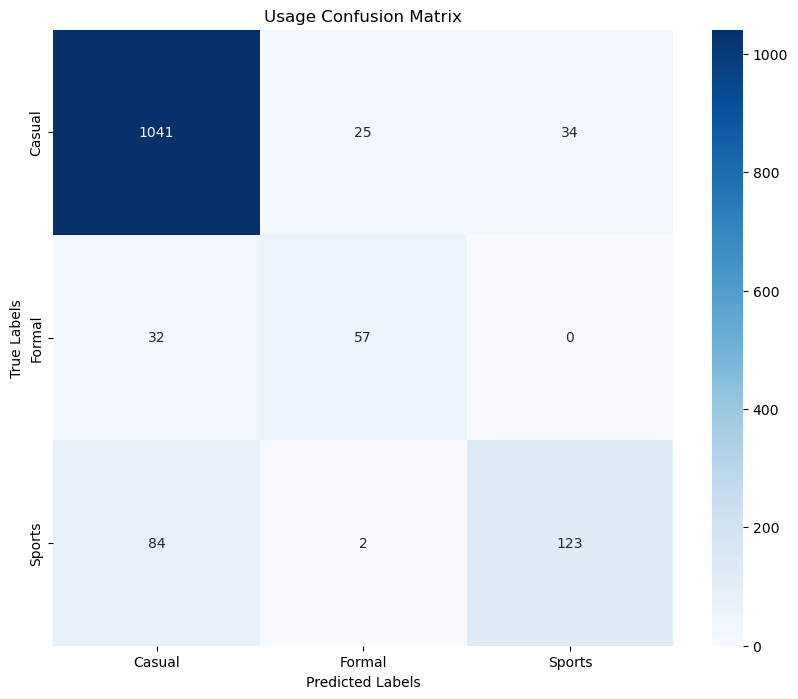

Usage Classification Report:

              precision    recall  f1-score   support

      Casual       0.90      0.95      0.92      1100
      Formal       0.68      0.64      0.66        89
      Sports       0.78      0.59      0.67       209

    accuracy                           0.87      1398
   macro avg       0.79      0.73      0.75      1398
weighted avg       0.87      0.87      0.87      1398



In [66]:
create_evaluation(model5, test_generator, target_names)

## Evaluate 6th Model (ResNet50 Model Grayscale images)

44/44 [==============================] - 93s 2s/step


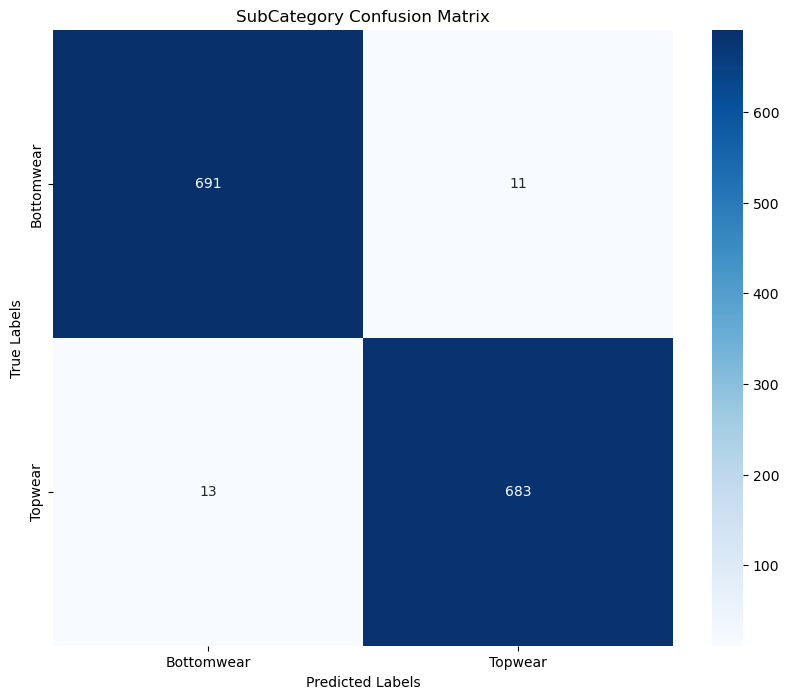

SubCategory Classification Report:

              precision    recall  f1-score   support

  Bottomwear       0.98      0.98      0.98       702
     Topwear       0.98      0.98      0.98       696

    accuracy                           0.98      1398
   macro avg       0.98      0.98      0.98      1398
weighted avg       0.98      0.98      0.98      1398



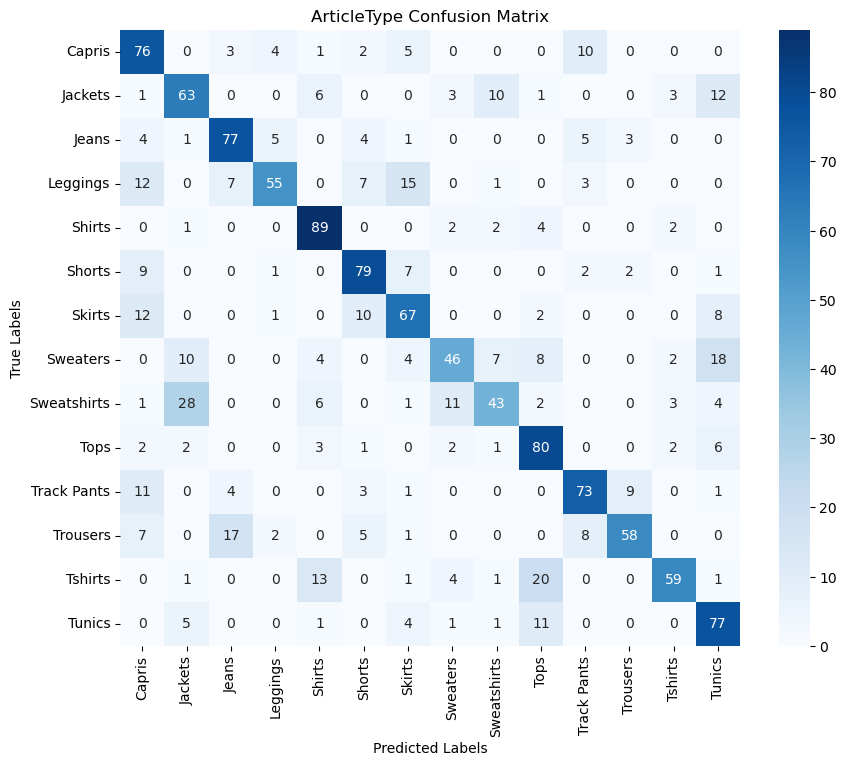

ArticleType Classification Report:

              precision    recall  f1-score   support

      Capris       0.56      0.75      0.64       101
     Jackets       0.57      0.64      0.60        99
       Jeans       0.71      0.77      0.74       100
    Leggings       0.81      0.55      0.65       100
      Shirts       0.72      0.89      0.80       100
      Shorts       0.71      0.78      0.75       101
      Skirts       0.63      0.67      0.65       100
    Sweaters       0.67      0.46      0.55        99
 Sweatshirts       0.65      0.43      0.52        99
        Tops       0.62      0.81      0.70        99
 Track Pants       0.72      0.72      0.72       102
    Trousers       0.81      0.59      0.68        98
     Tshirts       0.83      0.59      0.69       100
      Tunics       0.60      0.77      0.68       100

    accuracy                           0.67      1398
   macro avg       0.69      0.67      0.67      1398
weighted avg       0.69      0.67      0.67 

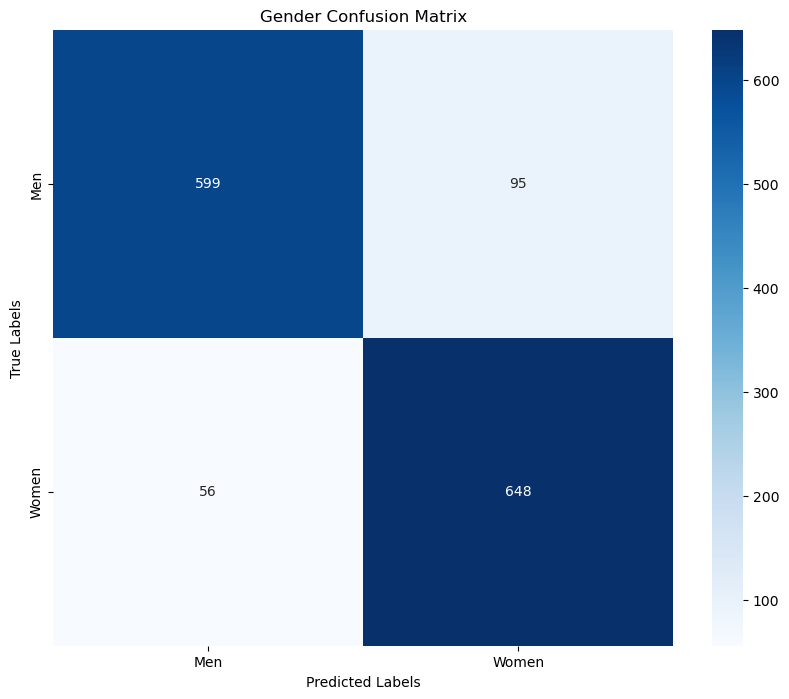

Gender Classification Report:

              precision    recall  f1-score   support

         Men       0.91      0.86      0.89       694
       Women       0.87      0.92      0.90       704

    accuracy                           0.89      1398
   macro avg       0.89      0.89      0.89      1398
weighted avg       0.89      0.89      0.89      1398



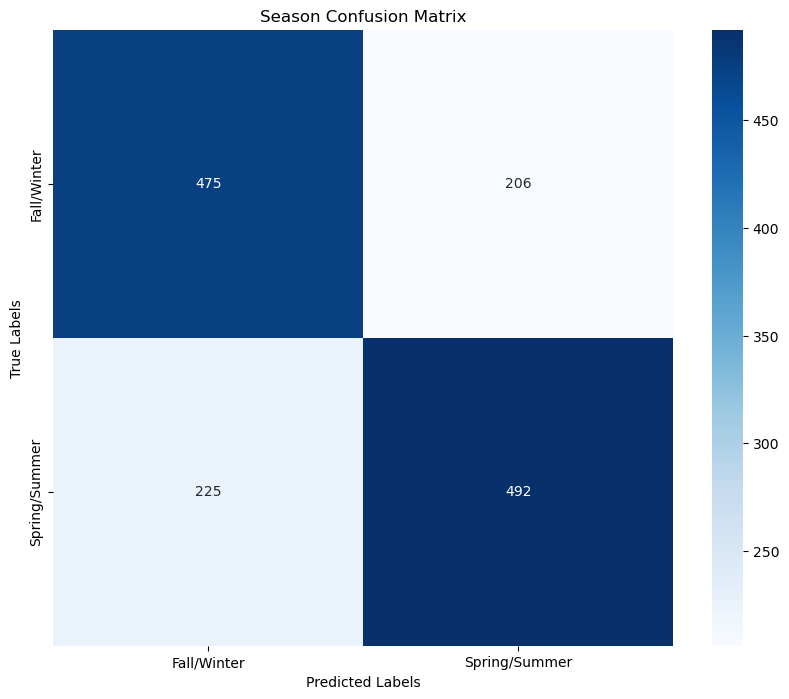

Season Classification Report:

               precision    recall  f1-score   support

  Fall/Winter       0.68      0.70      0.69       681
Spring/Summer       0.70      0.69      0.70       717

     accuracy                           0.69      1398
    macro avg       0.69      0.69      0.69      1398
 weighted avg       0.69      0.69      0.69      1398



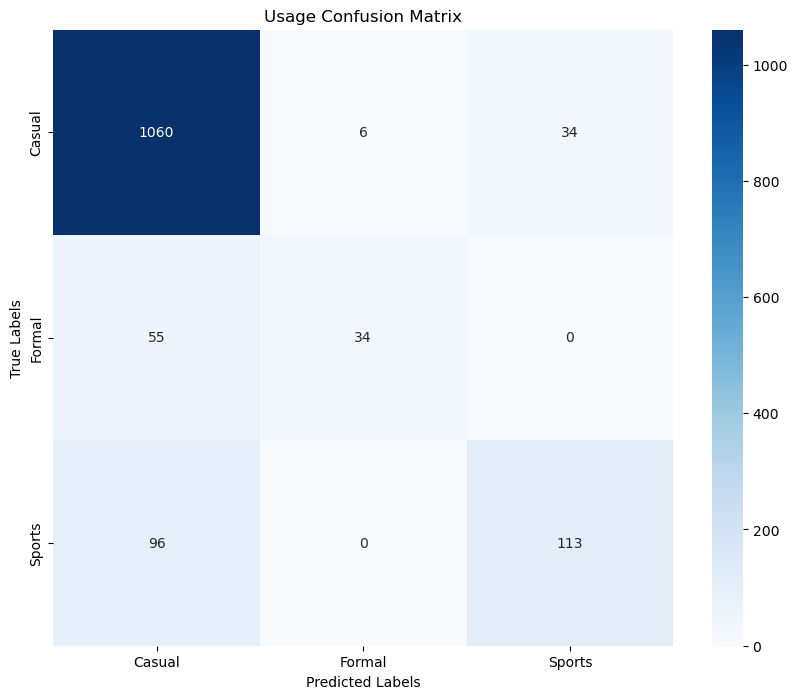

Usage Classification Report:

              precision    recall  f1-score   support

      Casual       0.88      0.96      0.92      1100
      Formal       0.85      0.38      0.53        89
      Sports       0.77      0.54      0.63       209

    accuracy                           0.86      1398
   macro avg       0.83      0.63      0.69      1398
weighted avg       0.86      0.86      0.85      1398



In [67]:
create_evaluation(model6, test_generator, target_names)

## Evaluate 7th Model (EfficientNetv2-S Model Grayscale Images with trainable Top Pre-Trained Layers)

44/44 [==============================] - 104s 2s/step


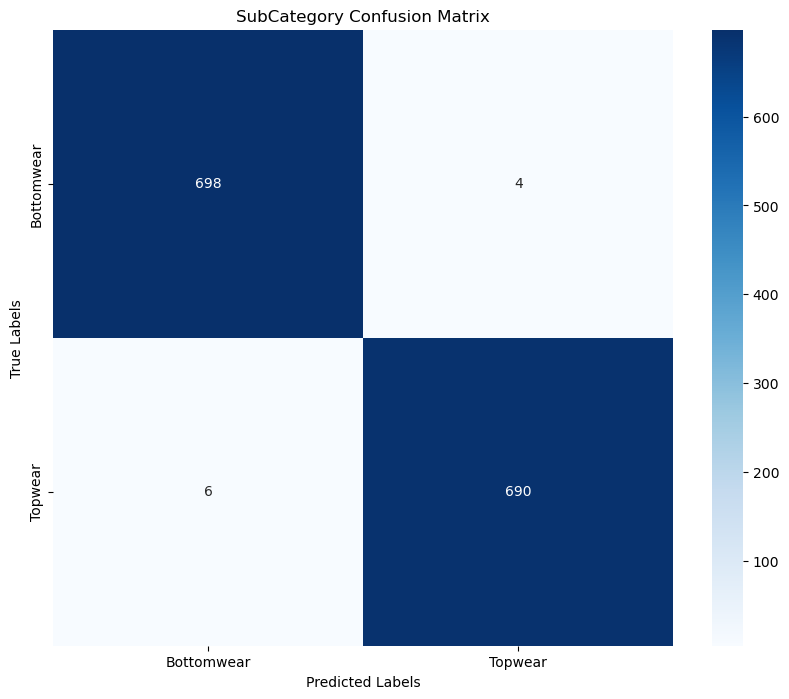

SubCategory Classification Report:

              precision    recall  f1-score   support

  Bottomwear       0.99      0.99      0.99       702
     Topwear       0.99      0.99      0.99       696

    accuracy                           0.99      1398
   macro avg       0.99      0.99      0.99      1398
weighted avg       0.99      0.99      0.99      1398



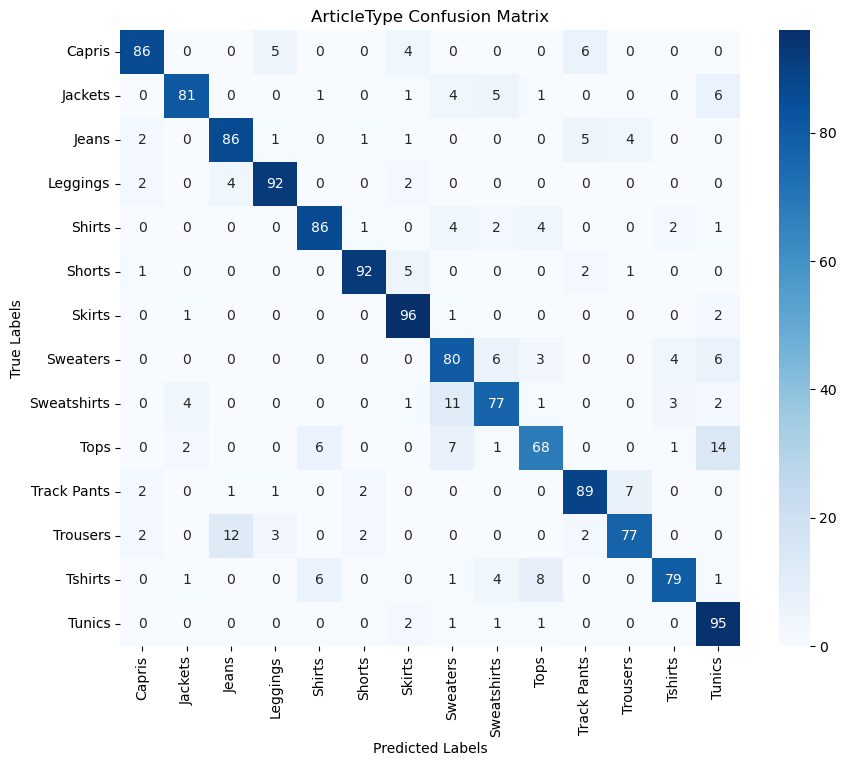

ArticleType Classification Report:

              precision    recall  f1-score   support

      Capris       0.91      0.85      0.88       101
     Jackets       0.91      0.82      0.86        99
       Jeans       0.83      0.86      0.85       100
    Leggings       0.90      0.92      0.91       100
      Shirts       0.87      0.86      0.86       100
      Shorts       0.94      0.91      0.92       101
      Skirts       0.86      0.96      0.91       100
    Sweaters       0.73      0.81      0.77        99
 Sweatshirts       0.80      0.78      0.79        99
        Tops       0.79      0.69      0.74        99
 Track Pants       0.86      0.87      0.86       102
    Trousers       0.87      0.79      0.82        98
     Tshirts       0.89      0.79      0.84       100
      Tunics       0.75      0.95      0.84       100

    accuracy                           0.85      1398
   macro avg       0.85      0.85      0.85      1398
weighted avg       0.85      0.85      0.85 

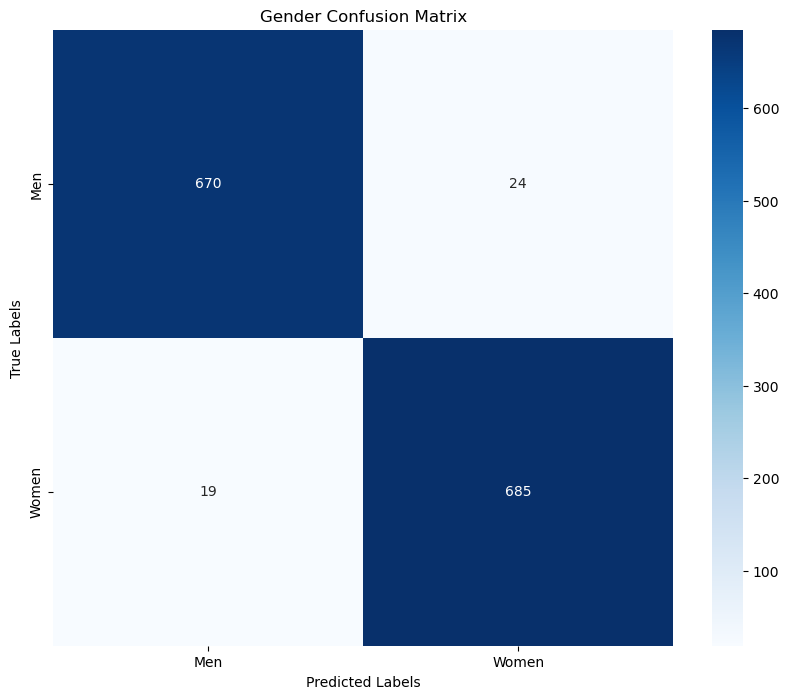

Gender Classification Report:

              precision    recall  f1-score   support

         Men       0.97      0.97      0.97       694
       Women       0.97      0.97      0.97       704

    accuracy                           0.97      1398
   macro avg       0.97      0.97      0.97      1398
weighted avg       0.97      0.97      0.97      1398



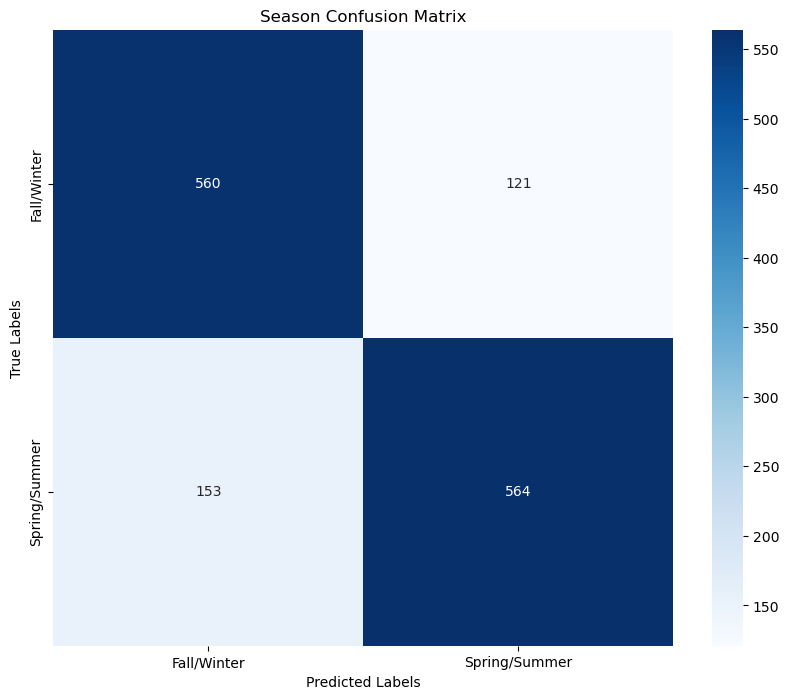

Season Classification Report:

               precision    recall  f1-score   support

  Fall/Winter       0.79      0.82      0.80       681
Spring/Summer       0.82      0.79      0.80       717

     accuracy                           0.80      1398
    macro avg       0.80      0.80      0.80      1398
 weighted avg       0.80      0.80      0.80      1398



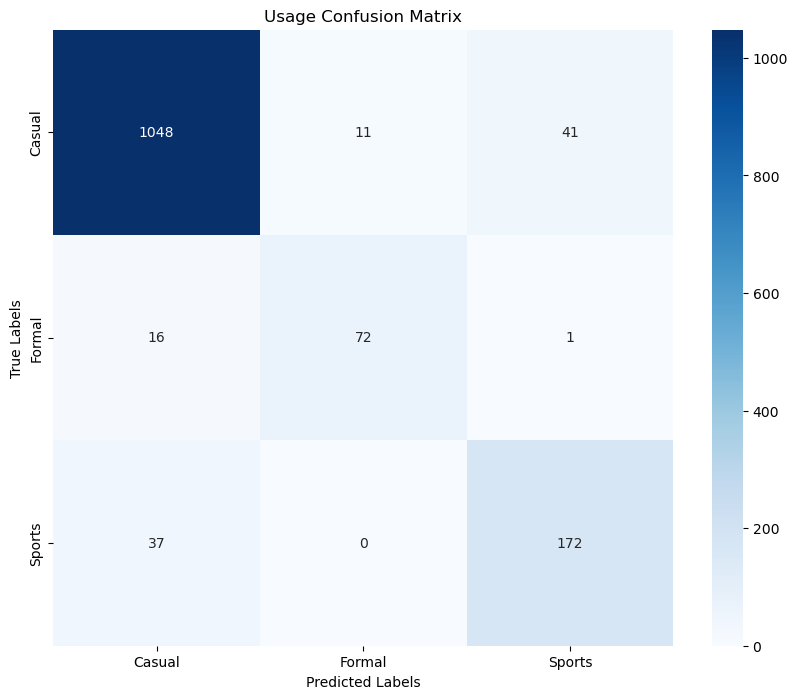

Usage Classification Report:

              precision    recall  f1-score   support

      Casual       0.95      0.95      0.95      1100
      Formal       0.87      0.81      0.84        89
      Sports       0.80      0.82      0.81       209

    accuracy                           0.92      1398
   macro avg       0.87      0.86      0.87      1398
weighted avg       0.92      0.92      0.92      1398



In [68]:
create_evaluation(model7, test_generator, target_names)

## Evaluate 8th Model (ResNet50 Model Grayscale Images with Trainable Top Pre-Trained Layers)

44/44 [==============================] - 93s 2s/step


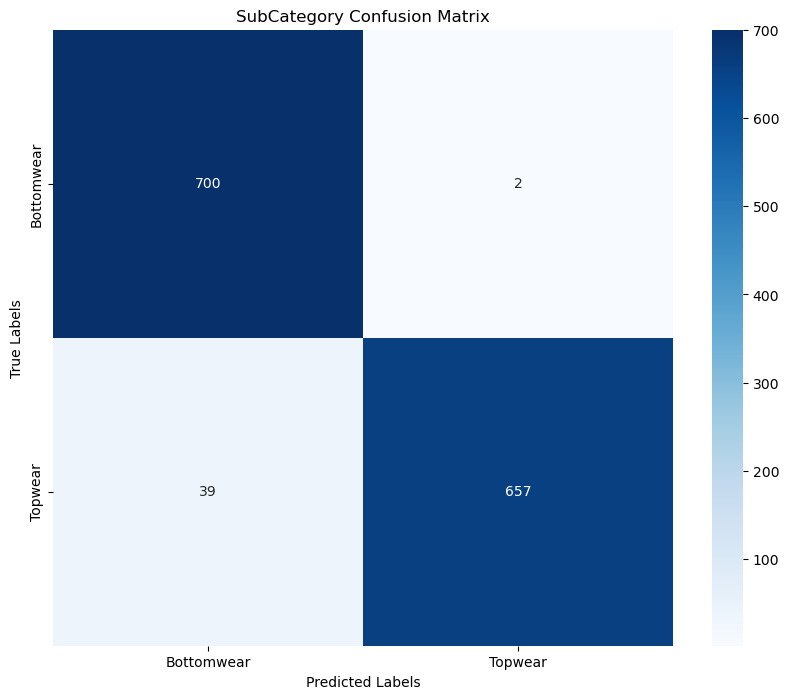

SubCategory Classification Report:

              precision    recall  f1-score   support

  Bottomwear       0.95      1.00      0.97       702
     Topwear       1.00      0.94      0.97       696

    accuracy                           0.97      1398
   macro avg       0.97      0.97      0.97      1398
weighted avg       0.97      0.97      0.97      1398



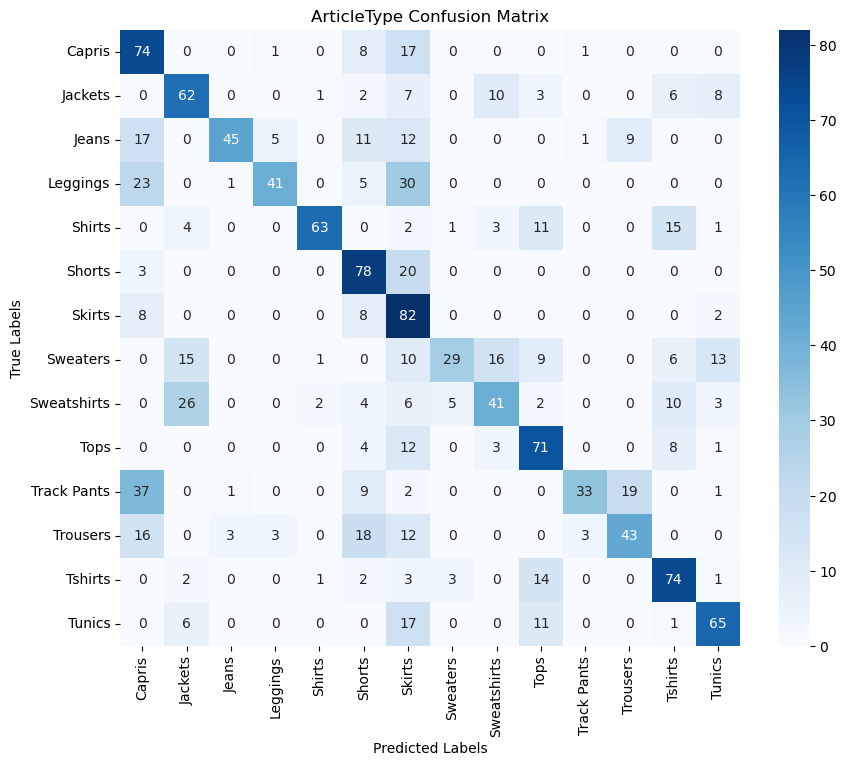

ArticleType Classification Report:

              precision    recall  f1-score   support

      Capris       0.42      0.73      0.53       101
     Jackets       0.54      0.63      0.58        99
       Jeans       0.90      0.45      0.60       100
    Leggings       0.82      0.41      0.55       100
      Shirts       0.93      0.63      0.75       100
      Shorts       0.52      0.77      0.62       101
      Skirts       0.35      0.82      0.49       100
    Sweaters       0.76      0.29      0.42        99
 Sweatshirts       0.56      0.41      0.48        99
        Tops       0.59      0.72      0.65        99
 Track Pants       0.87      0.32      0.47       102
    Trousers       0.61      0.44      0.51        98
     Tshirts       0.62      0.74      0.67       100
      Tunics       0.68      0.65      0.67       100

    accuracy                           0.57      1398
   macro avg       0.65      0.57      0.57      1398
weighted avg       0.65      0.57      0.57 

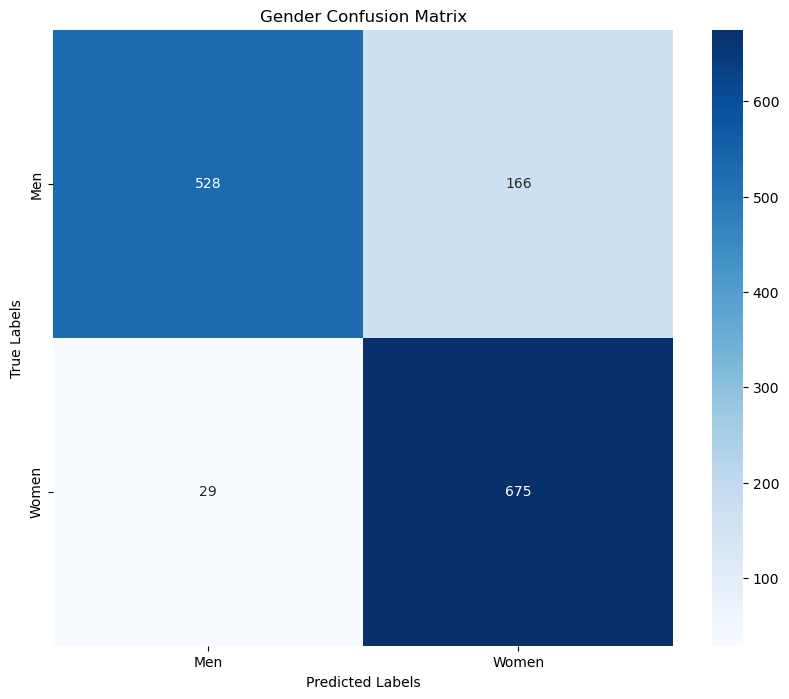

Gender Classification Report:

              precision    recall  f1-score   support

         Men       0.95      0.76      0.84       694
       Women       0.80      0.96      0.87       704

    accuracy                           0.86      1398
   macro avg       0.88      0.86      0.86      1398
weighted avg       0.87      0.86      0.86      1398



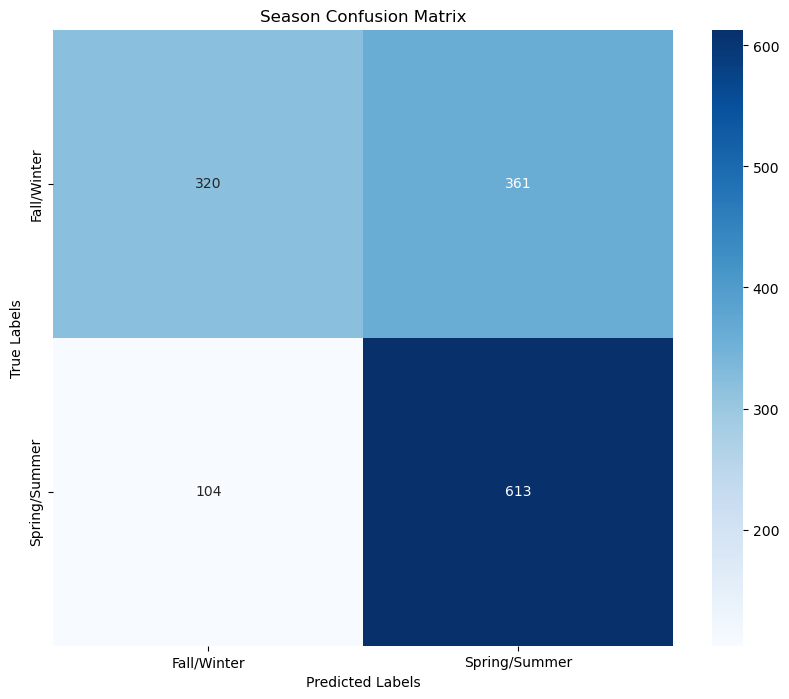

Season Classification Report:

               precision    recall  f1-score   support

  Fall/Winter       0.75      0.47      0.58       681
Spring/Summer       0.63      0.85      0.73       717

     accuracy                           0.67      1398
    macro avg       0.69      0.66      0.65      1398
 weighted avg       0.69      0.67      0.65      1398



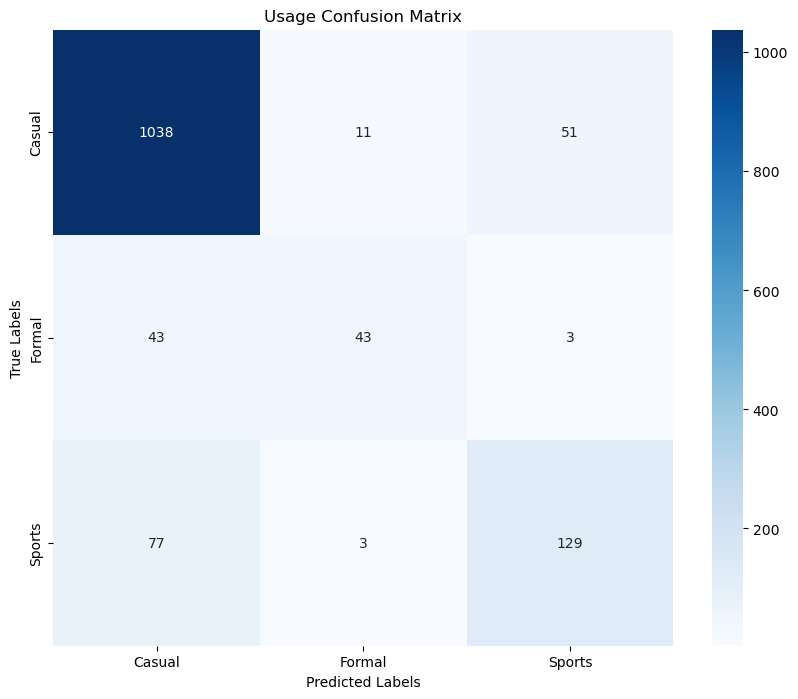

Usage Classification Report:

              precision    recall  f1-score   support

      Casual       0.90      0.94      0.92      1100
      Formal       0.75      0.48      0.59        89
      Sports       0.70      0.62      0.66       209

    accuracy                           0.87      1398
   macro avg       0.79      0.68      0.72      1398
weighted avg       0.86      0.87      0.86      1398



In [69]:
create_evaluation(model8, test_generator, target_names)

## Summary

In [82]:
models = [model, model2, model3, model4, model5, model6, model7, model8]

for i in range(len(models)):

    print(f'Model {i+1}')

    x = models[i].evaluate(train_generator)
    print('Train Loss')
    print(round(x[0], 2))
    print('Train Avg Output Accuracy')
    print(round((x[6] + x[7] + x[8] + x[9] + x[10])/5*100, 1))

    x = models[i].evaluate(validation_generator)
    print('Evaluation Loss')
    print(round(x[0], 2))
    print('Evaluation Avg Output Accuracy')
    print(round((x[6] + x[7] + x[8] + x[9] + x[10])/5*100, 1))

    x = models[i].evaluate(test_generator)
    print('Test Loss')
    print(round(x[0], 2))
    print('Test Avg Output Accuracy')
    print(round((x[6] + x[7] + x[8] + x[9] + x[10])/5*100, 1))
    print()

Model 1
350/350 [==============================] - 766s 2s/step - loss: 2.2592 - subCategory_output_loss: 0.0516 - articleType_output_loss: 0.9699 - gender_output_loss: 0.2524 - season_output_loss: 0.5967 - usage_output_loss: 0.3886 - subCategory_output_accuracy: 0.9787 - articleType_output_accuracy: 0.6454 - gender_output_accuracy: 0.8912 - season_output_accuracy: 0.6815 - usage_output_accuracy: 0.8513
Train Loss
2.26
Train Avg Output Accuracy
81.0
44/44 [==============================] - 93s 2s/step - loss: 2.3834 - subCategory_output_loss: 0.0657 - articleType_output_loss: 1.0578 - gender_output_loss: 0.2558 - season_output_loss: 0.5973 - usage_output_loss: 0.4069 - subCategory_output_accuracy: 0.9750 - articleType_output_accuracy: 0.6141 - gender_output_accuracy: 0.8973 - season_output_accuracy: 0.6840 - usage_output_accuracy: 0.8466
Evaluation Loss
2.38
Evaluation Avg Output Accuracy
80.3
44/44 [==============================] - 94s 2s/step - loss: 2.3725 - subCategory_output_loss

### Average Output Accuracy per Model and Dataset

| Models | Train Avg Output Accuracy | Evaluation Avg Output Accuracy | Test Avg Output Accuracy |
| :---   |  ---: |       ---: | ---: |
| 1. EfficientNetv2-S Model with Reduce LR | 81.0 | 80.3 | 79.8 |
| 2. ResNet50 Model with Reduce LR | 82.0  | 79.2 | 79.1 |
| 3. EfficientNetv2-S Model without changing LR | 85.8 | 82.8 | 82.6 |
| 4. ResNet50 Model without changing LR | 86.6 | 81.4 | 81.6 |
| 5. EfficientNetv2-S Model Grayscale Images | 85.6 | 82.2 | 82.4 |
| 6. ResNet50 Model Grayscale Images | 87.2 | 82.5 | 82.1 |
| 7. EfficientNetv2-S Model Grayscale with Trainable Top Pre-Trained Layers | 96.4 | 90.0 | 90.7 |
| 8. ResNet50 Model Grayscale with Trainable Top Pre-Trained Layers | 80.4 | 78.5 | 78.7 |

### Loss per Model and Dataset

| Models | Train Loss | Evaluation Loss | Test Loss |
| :---   |  ---: |       ---: | ---: |
| 1. EfficientNetv2-S Model with Reduce LR | 2.26 | 2.38 | 2.37 |
| 2. ResNet50 Model with Reduce LR | 2.13 | 2.50 | 2.47 |
| 3. EfficientNetv2-S Model without changing LR | 1.72 | 2.11 | 2.08 |
| 4. ResNet50 Model without changing LR | 1.62 | 2.26 | 2.18 |
| 5. EfficientNetv2-S Model Grayscale Images | 1.77 | 2.12 | 2.09 |
| 6. ResNet50 Model Grayscale Images | 1.55 | 2.16 | 2.18 |
| 7. EfficientNetv2-S Model Grayscale with Trainable Top Pre-Trained Layers | 0.51 | 1.28 | 1.20 |
| 8. ResNet50 Model Grayscale with Trainable Top Pre-Trained Layers | 2.39 | 2.61 | 2.60 |